In [1]:
import pytensor

# set flag to hotfix open c++ errors
pytensor.config.cxx = "/usr/bin/clang++"

In [3]:
# import plotly.express as px
# import plotly.graph_objects as go
# import squarify
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

from pymc_marketing import clv
from pymc_marketing.clv.utils import rfm_segments, rfm_summary

az.style.use("arviz-darkgrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

random_seed = 2025

%config InlineBackend.figure_format = "retina"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
order_data = pd.read_csv(
    r"order_data_6-2-2024.csv",
)

/var/folders/fg/0gjlwtr11dd51xt6hkb8qw6h0000gn/T/ipykernel_15942/4073588001.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  order_data = pd.read_csv(


In [5]:
order_data

EQUI_ID  ORDER_DATE  PERIOD_YEAR  COUNTRY_KEY  INST_KEY  \
0         116.00  2004-02-10       200402        46.00     48.00   
1          30.00  2004-02-13       200402        42.00      7.00   
2          27.00  2004-02-16       200402        42.00      5.00   
3         891.00  2004-02-05       200402        42.00    403.00   
4          21.00  2004-01-30       200402       121.00      1.00   
...          ...         ...          ...          ...       ...   
199656  9,766.00  2024-01-31       202402        25.00  3,657.00   
199657  4,253.00  2024-01-30       202402        33.00  1,700.00   
199658    249.00  2024-01-29       202402       104.00    100.00   
199659 10,578.00  2024-01-29       202402        46.00  3,775.00   
199660 11,814.00  2024-01-11       202402        25.00  3,967.00   

        EQUI_COMM_DATE  PRODUCT_LINE  ENG_APPL  VESSEL_SEGMENT  \
0             19910715          2.00      1.00            0.00   
1             19850611          2.00      1.00            0.00   
2                    0          2.00      1.00            3.00   
3             19890203          2.00     15.00            3.00   
4             19940114          2.00     15.00           10.00   
...                ...           ...       ...             ...   
199656        20160702          2.00     15.00            5.00   
199657        20090822          2.00     15.00            6.00   
199658        19910606          2.00     15.00           10.00   
199659        20170401          1.00     15.00            3.00   
199660        20220503          2.00      1.00            3.00   

        INST_SCRAPPED_DATE  PROD_REF_TYPE_ID  CUST_KEY  BUSINESS_SEGMENT_KEY  \
0                      NaN             10.00    143.00                 11.00   
1                      NaN             10.00      3.00                 11.00   
2            20,110,506.00              4.00      1.00                  4.00   
3                      NaN             10.00     30.00                  4.00   
4                      NaN             10.00    448.00                 13.00   
...                    ...               ...       ...                   ...   
199656                 NaN            364.00  5,939.00                  8.00   
199657                 NaN            362.00  4,086.00                  8.00   
199658                 NaN             10.00  3,163.00                 13.00   
199659                 NaN            354.00  5,608.00                  4.00   
199660                 NaN            359.00  5,601.00                  4.00   

       INST_COMM_DATE  INST_TYPE_KEY  M_NET_SALES  M_VALUE_GROSS_REVENUE  \
0       19,910,715.00          23.00    13,911.36              13,753.90   
1       19,850,812.00          31.00       330.60                 348.00   
2       19,840,910.00         101.00       124.80                 128.90   
3       19,890,203.00           1.00     2,371.02               2,315.80   
4       19,940,103.00          67.00     1,114.16               1,104.00   
...               ...            ...          ...                    ...   
199656  20,160,702.00         104.00    43,304.51              44,972.60   
199657  20,090,822.00          53.00     1,289.60               1,612.00   
199658  19,910,606.00          52.00     1,017.00               1,017.00   
199659  20,170,401.00          12.00     6,449.68               9,328.01   
199660  20,220,503.00          17.00    30,624.90              22,499.90   

        M_VALUE_CS_GROSS_REVENUE  M_FREIGHT  M_DISC_TOT  owner  operator  \
0                           0.00     157.46        0.00    NaN       NaN   
1                           0.00       0.00      -17.40    NaN       NaN   
2                           0.00       8.79      -12.89    NaN       NaN   
3                           0.00     194.18     -138.96    NaN       NaN   
4                           0.00      10.16        0.00    NaN       NaN   
...                          ...        ...         ...    ...       

In [6]:
order_data = order_data[order_data["CUST_VALUE_CATEGORY"] == 1]

In [7]:
# filthy_date_cols = ["ORDER_DATE", "INST_COMM_DATE", "INST_SCRAPPED_DATE"]

# def safe_parse_date(raw_date):
#     if pd.isnull(raw_date):
#         return pd.NaT

#     if isinstance(raw_date, (int, float)):
#         date_str = str(int(raw_date))
#     elif isinstance(raw_date, str) and raw_date.replace('.', '', 1).isdigit():
#         date_str = str(int(float(raw_date)))
#     else:
#         date_str = str(raw_date)

#     try:
#         return parser.parse(date_str)
#     except (ValueError, OverflowError):
#         return pd.NaT

In [8]:
# filthy_date_cols = ["ORDER_DATE", "INST_COMM_DATE", "INST_SCRAPPED_DATE"]

# for col in filthy_date_cols:
#     order_data[col] = pd.to_datetime(order_data[col], errors='coerce')

In [9]:
order_data_filtered = order_data[
    ["INST_KEY", "ORDER_DATE", "M_NET_SALES", "INST_SCRAPPED_DATE"]
].copy()

order_data_filtered = order_data_filtered[
    (order_data_filtered["M_NET_SALES"] > 50)
    & (order_data_filtered["M_NET_SALES"] < 4000000)
    & (order_data_filtered["INST_SCRAPPED_DATE"].isna())
].copy()

In [10]:
order_data_filtered

INST_KEY  ORDER_DATE  M_NET_SALES  INST_SCRAPPED_DATE
0          48.00  2004-02-10    13,911.36                 NaN
6          63.00  2004-02-12     3,994.43                 NaN
7         435.00  2004-02-02       938.11                 NaN
10         41.00  2004-02-09     2,488.16                 NaN
12        155.00  2004-02-11     1,810.03                 NaN
...          ...         ...          ...                 ...
199641  3,400.00  2024-01-29    13,893.57                 NaN
199642    464.00  2024-01-11     5,633.87                 NaN
199644  2,548.00  2024-01-30        86.30                 NaN
199647  3,927.00  2023-12-15    18,755.00                 NaN
199660  3,967.00  2024-01-11    30,624.90                 NaN

[46619 rows x 4 columns]

In [11]:
order_data_filtered.columns = order_data_filtered.columns.str.lower()

In [12]:
rfm_df = rfm_summary(
    order_data_filtered,
    customer_id_col="inst_key",
    datetime_col="order_date",
    monetary_value_col="m_net_sales",
    time_unit="W",  # "M" & "Y" are unsupported TimeDelta units in pandas,
    time_scaler=52,  # so Weeks must be rescaled into Years
    include_first_transaction=False,  # set to True for RFM Segmentation, False for modeling
)

In [13]:
rfm_df

customer_id  frequency  recency     T  monetary_value
0            0.00       0.00     0.00  9.94            0.00
1            1.00       1.00    13.46 15.12        2,676.46
2            3.00       5.00     2.62 19.85        1,890.58
3            7.00       0.00     0.00 15.50            0.00
4            8.00      35.00    16.90 17.08        6,446.26
...           ...        ...      ...   ...             ...
3018     4,063.00       2.00     0.31  0.83       10,418.05
3019     4,064.00       0.00     0.00  1.10            0.00
3020     4,065.00       0.00     0.00  0.85            0.00
3021     4,066.00       0.00     0.00  0.75            0.00
3022     4,067.00       1.00     0.35  0.42       17,716.41

[3023 rows x 5 columns]

In [14]:
rfm_df = rfm_df.query("frequency > 0")
rfm_df["customer_id"] = rfm_df.index

/var/folders/fg/0gjlwtr11dd51xt6hkb8qw6h0000gn/T/ipykernel_15942/2774044154.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df["customer_id"] = rfm_df.index


In [15]:
def create_rfm_data(
    transactions,
    customer_id_col,
    datetime_col,
    monetary_value_col,
    observation_period_end=None,
    datetime_format=None,
    time_unit=None,
    time_scaler=None,
    include_first_transaction=False,
    sort_transactions=True,
    zero_frequency=False,
):
    # Creating data for modeling
    rfm_summary_df = rfm_summary(
        transactions=transactions,
        customer_id_col=customer_id_col,
        datetime_col=datetime_col,
        monetary_value_col=monetary_value_col,
        observation_period_end=observation_period_end,
        datetime_format=datetime_format,
        time_unit=time_unit,
        time_scaler=time_scaler,
        include_first_transaction=include_first_transaction,
        sort_transactions=sort_transactions,
    )

    # Creating data with segments
    rfm_segments_df = rfm_segments(
        transactions=transactions,
        customer_id_col=customer_id_col,
        datetime_col=datetime_col,
        monetary_value_col=monetary_value_col,
        observation_period_end=observation_period_end,
        datetime_format=datetime_format,
        time_unit=time_unit,
        time_scaler=time_scaler,
        sort_transactions=sort_transactions,
    )

    # Removing 0 frequency for modeling
    if zero_frequency == False:
        rfm_segments_df = rfm_segments_df.query("frequency > 0")
        rfm_summary_df = rfm_summary_df.query("frequency > 0")

    # Merging modeling data with segmented data
    rfm_data = pd.merge(rfm_summary_df, rfm_segments_df, on=customer_id_col, how="left")

    return rfm_data

In [16]:
rfm_segs = rfm_segments(
    order_data_filtered,
    customer_id_col="inst_key",
    datetime_col="order_date",
    monetary_value_col="m_net_sales",
    time_unit="W",  # "M" & "Y" are unsupported TimeDelta units in pandas,
    time_scaler=52,  # so Weeks must be rescaled into Years
)

In [17]:
rfm_segs.query("frequency > 0")

customer_id  frequency  recency  monetary_value rfm_score  \
0            0.00       1.00     9.94        2,543.82       212   
1            1.00       2.00     1.65        2,374.05       412   
2            3.00       6.00    17.23        1,662.34       121   
3            7.00       1.00    15.50          648.00       111   
4            8.00      36.00     0.17        6,272.59       433   
...           ...        ...      ...             ...       ...   
3018     4,063.00       3.00     0.52        8,143.50       413   
3019     4,064.00       1.00     1.10       11,898.90       413   
3020     4,065.00       1.00     0.85       64,916.05       414   
3021     4,066.00       1.00     0.75       56,906.61       414   
3022     4,067.00       2.00     0.08        9,439.57       413   

                segment  
0      At Risk Customer  
1      At Risk Customer  
2                 Other  
3     Inactive Customer  
4      Premium Customer  
...                 ...  
3018        Top Spender  
3019        Top Spender  
3020        Top Spender  
3021        Top Spender  
3022        Top Spender  

[3023 rows x 6 columns]

In [18]:
rfm_df_joined = rfm_df.merge(
    rfm_segs[["customer_id", "rfm_score", "segment"]],  # keep only the segment info
    on="customer_id",
    how="inner",  # ensures all customers in rfm_df are retained
)

In [19]:
rfm_df_joined

customer_id  frequency  recency     T  monetary_value rfm_score  \
0               1       1.00    13.46 15.12        2,676.46       412   
1               7       2.00     0.27  2.23       15,465.06       111   
2               8      61.00    12.60 14.62      153,092.17       433   
3              11      46.00    18.13 18.19       22,762.86       422   
4              13     317.00    12.71 19.94       13,756.78       432   
...           ...        ...      ...   ...             ...       ...   
1436         2998     136.00     2.65  2.67       21,149.72       122   
1437         3002       1.00     2.29  2.37        3,204.00       211   
1438         3004       1.00     0.17  1.77        6,655.86       212   
1439         3006       2.00     0.19  0.40        6,746.47       114   
1440         3018       2.00     0.31  0.83       10,418.05       111   

                segment  
0      At Risk Customer  
1     Inactive Customer  
2      Premium Customer  
3      At Risk Customer  
4                 Other  
...                 ...  
1436   At Risk Customer  
1437  Inactive Customer  
1438   At Risk Customer  
1439  Inactive Customer  
1440  Inactive Customer  

[1441 rows x 7 columns]

In [20]:
rfm_df_model = rfm_df_joined.query("frequency > 0")

In [21]:
rfm_df_model

customer_id  frequency  recency     T  monetary_value rfm_score  \
0               1       1.00    13.46 15.12        2,676.46       412   
1               7       2.00     0.27  2.23       15,465.06       111   
2               8      61.00    12.60 14.62      153,092.17       433   
3              11      46.00    18.13 18.19       22,762.86       422   
4              13     317.00    12.71 19.94       13,756.78       432   
...           ...        ...      ...   ...             ...       ...   
1436         2998     136.00     2.65  2.67       21,149.72       122   
1437         3002       1.00     2.29  2.37        3,204.00       211   
1438         3004       1.00     0.17  1.77        6,655.86       212   
1439         3006       2.00     0.19  0.40        6,746.47       114   
1440         3018       2.00     0.31  0.83       10,418.05       111   

                segment  
0      At Risk Customer  
1     Inactive Customer  
2      Premium Customer  
3      At Risk Customer  
4                 Other  
...                 ...  
1436   At Risk Customer  
1437  Inactive Customer  
1438   At Risk Customer  
1439  Inactive Customer  
1440  Inactive Customer  

[1441 rows x 7 columns]

In [22]:
rfm_df_model["segment"] = rfm_df_model["segment"].str.replace("Other", "Low Spender")

In [23]:
segment_dfs = [segment for _, segment in rfm_df_model.groupby("segment")]
df1, df2, df3, df4, df5, df6 = segment_dfs

at_risk = df1.copy()
inactive = df2.copy()
low_spender = df3.copy()

premium = df4.copy()
repeat = df5.copy()
top = df6.copy()

## Sampler Kwargs

In [24]:
sampler_kwargs = {
    # "target_accept": 0.9,
    "chains": 4,
    "nuts_sampler": "nutpie",
    "compile_kwargs": {"mode": "numba"},
    "random_seed": random_seed,
}

### At Risk Segment

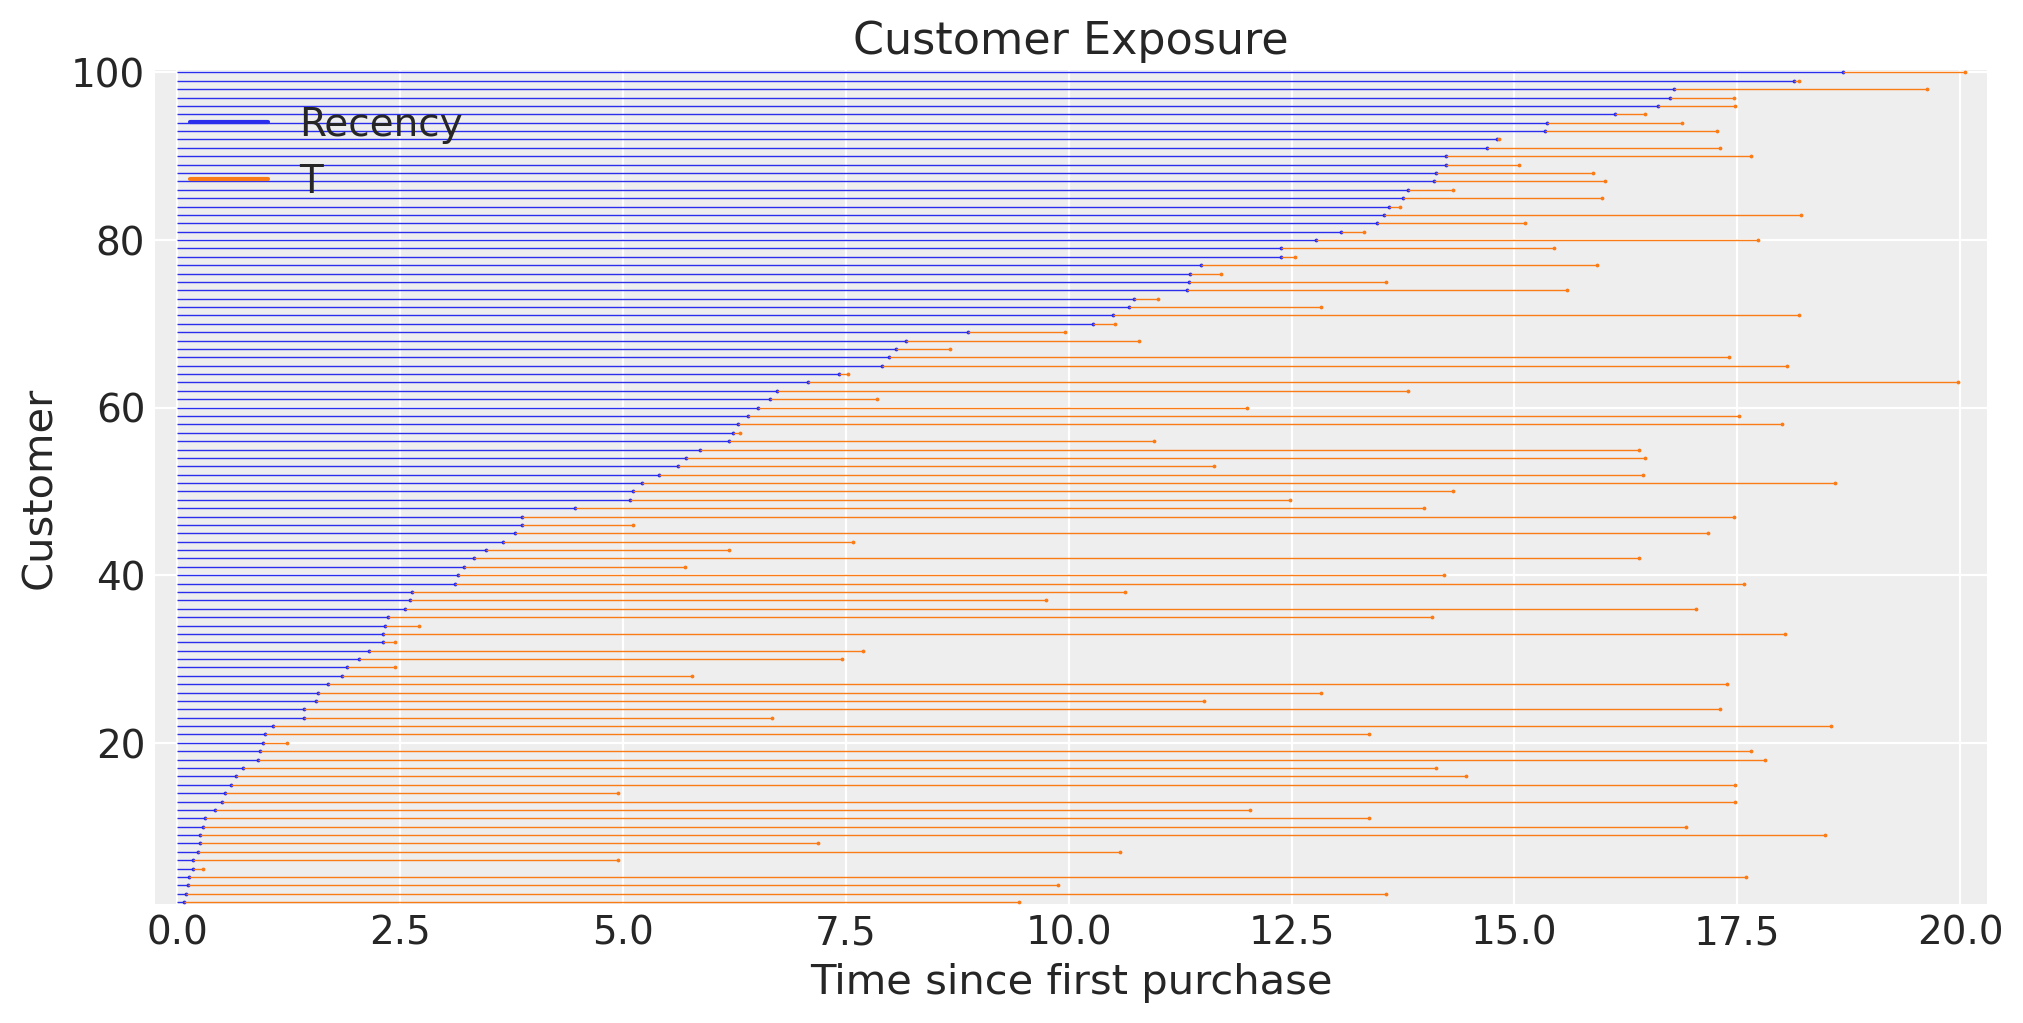

In [25]:
# Customer exposure plot for the at-risk segment

fig, ax = plt.subplots(figsize=(10, 5))
(
    at_risk.sample(n=100, random_state=random_seed)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

In [26]:
model = clv.GammaGammaModel(data=at_risk)
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [27]:
# idata_map = model.fit(method = "map").posterior.to_dataframe()

In [28]:
idata_mcmc = model.fit(**sampler_kwargs)

In [29]:
model.fit_summary()

mean       sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
p_log__    -0.36     0.21    -0.75     -0.00       0.01     0.01  1,230.00   
q_log__    -0.15     0.10    -0.33      0.04       0.00     0.00  1,761.00   
v_log__     8.75     0.35     8.08      9.37       0.01     0.01  1,176.00   
p           0.71     0.15     0.47      0.99       0.01     0.01  1,230.00   
q           0.87     0.09     0.71      1.02       0.00     0.00  1,761.00   
v       6,698.53 2,283.57 2,726.78 10,879.72      66.00    57.54  1,176.00   

         ess_tail  r_hat  
p_log__  1,393.00   1.00  
q_log__  1,765.00   1.00  
v_log__  1,356.00   1.00  
p        1,393.00   1.00  
q        1,765.00   1.00  
v        1,356.00   1.00

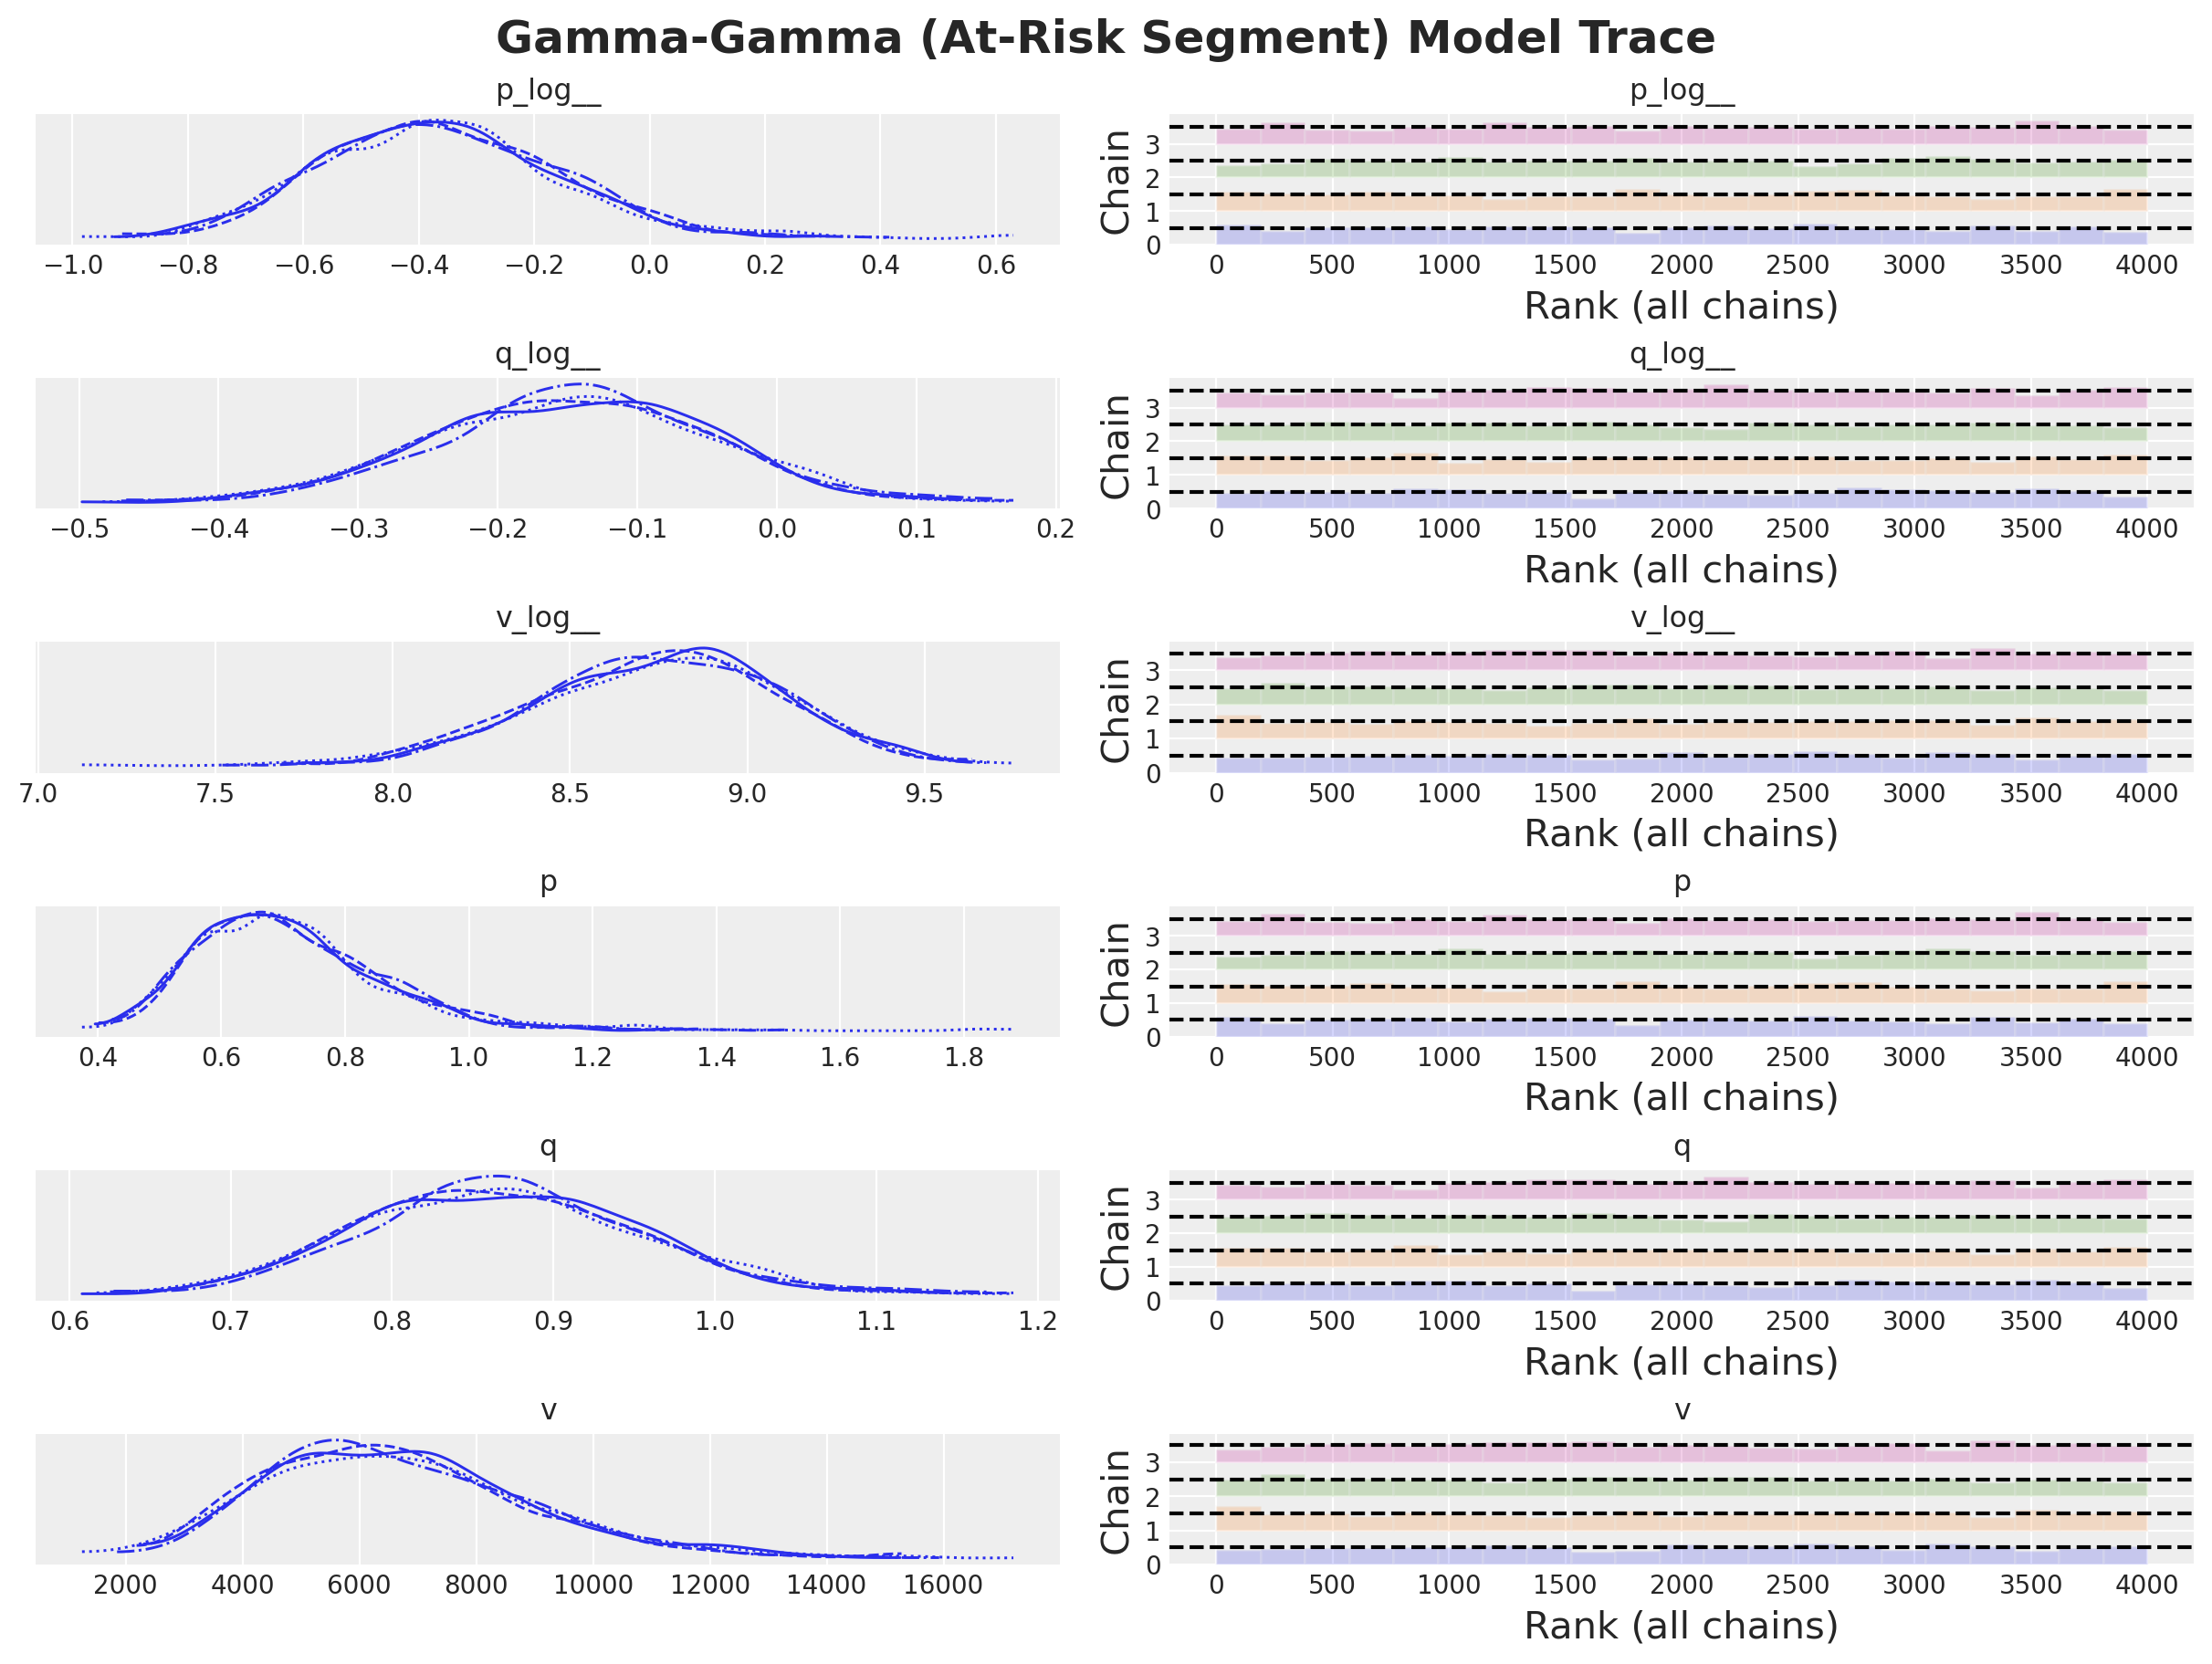

In [30]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Gamma-Gamma (At-Risk Segment) Model Trace", fontsize=18, fontweight="bold"
)
plt.show();

### Inactive Segment

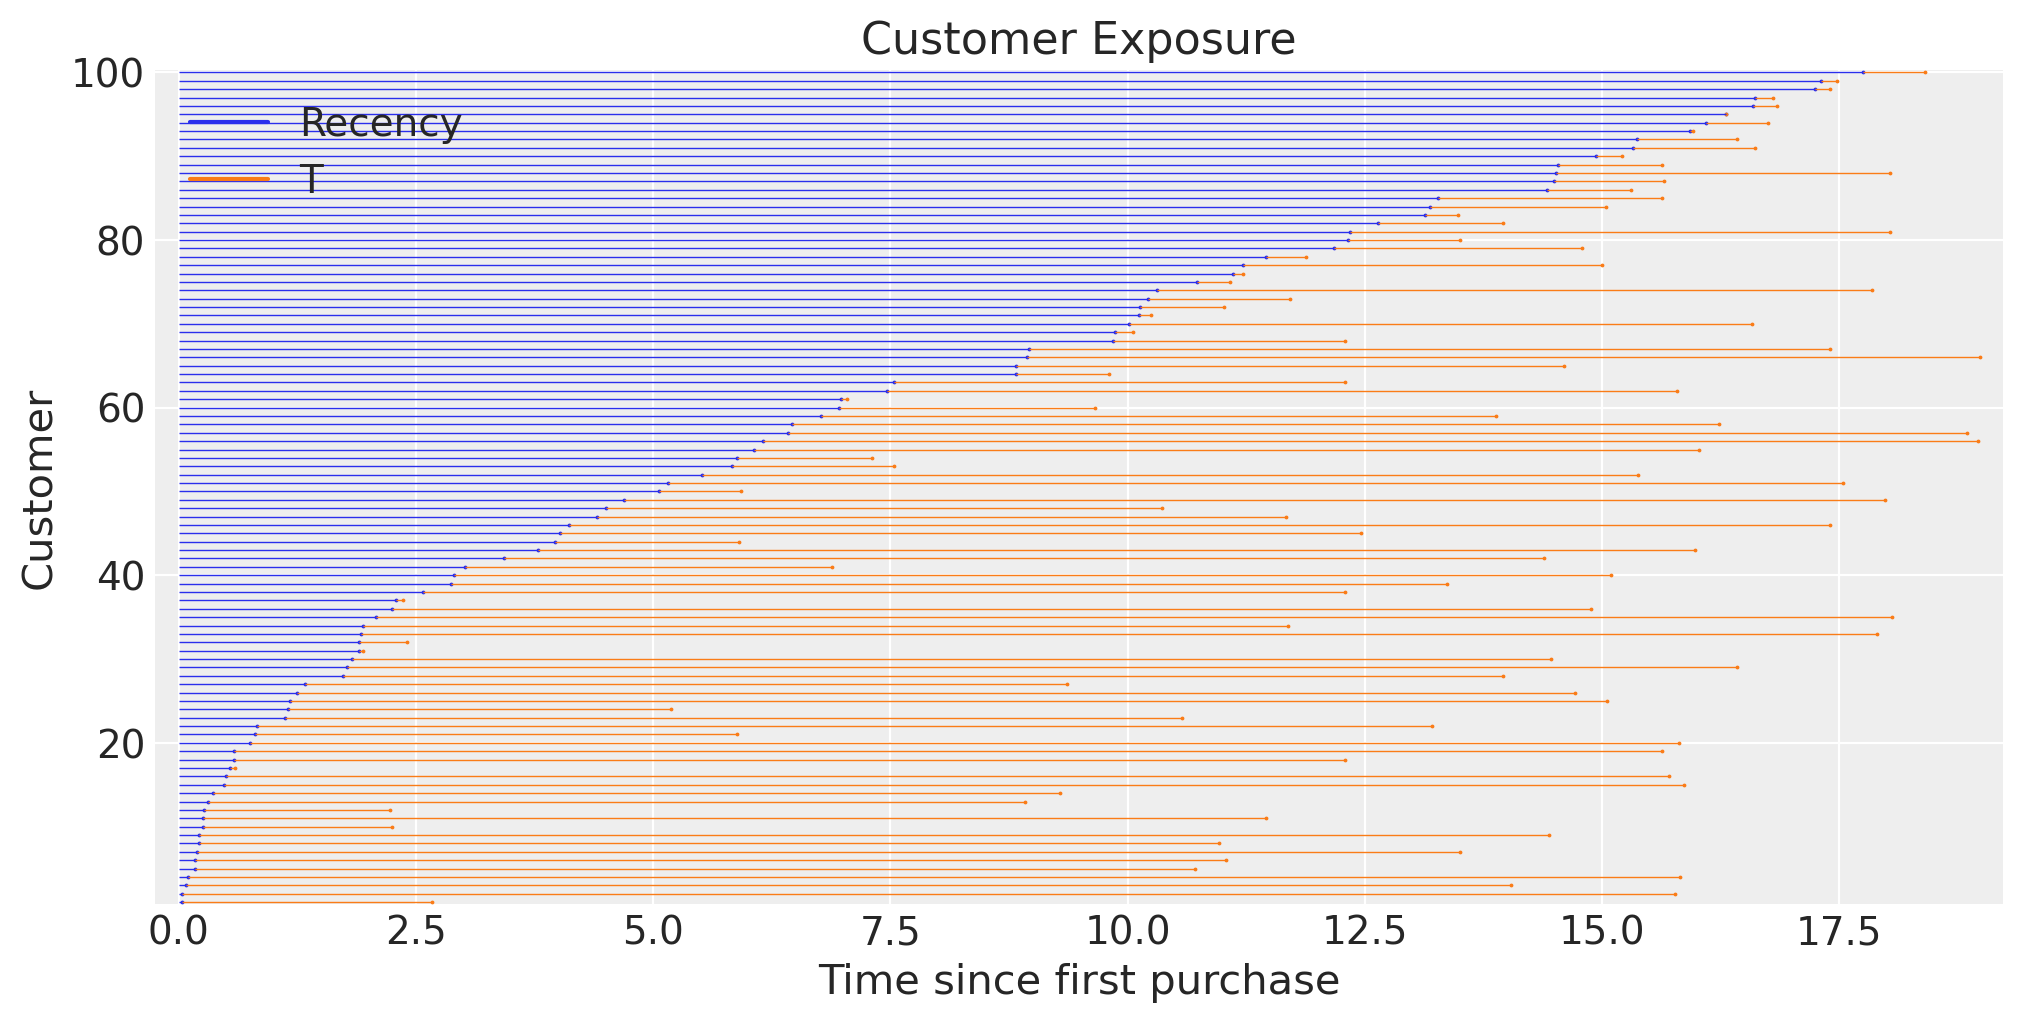

In [31]:
# Customer exposure plot for the inactive segment

fig, ax = plt.subplots(figsize=(10, 5))
(
    inactive.sample(n=100, random_state=random_seed)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

In [32]:
model = clv.GammaGammaModel(data=inactive)
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [33]:
idata_map = model.fit(method="map").posterior.to_dataframe()

Output()

In [34]:
idata_mcmc = model.fit(**sampler_kwargs)

In [35]:
model.fit_summary()

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
p_log__    -0.42     0.18    -0.74    -0.08       0.01     0.00  1,116.00   
q_log__    -0.31     0.08    -0.46    -0.15       0.00     0.00  1,668.00   
v_log__     8.66     0.31     8.08     9.26       0.01     0.01  1,035.00   
p           0.67     0.12     0.47     0.91       0.00     0.00  1,116.00   
q           0.74     0.06     0.63     0.85       0.00     0.00  1,668.00   
v       6,079.45 1,923.35 2,798.63 9,662.69      59.06    52.52  1,035.00   

         ess_tail  r_hat  
p_log__  1,065.00   1.00  
q_log__  1,820.00   1.00  
v_log__    915.00   1.00  
p        1,065.00   1.00  
q        1,820.00   1.00  
v          915.00   1.00

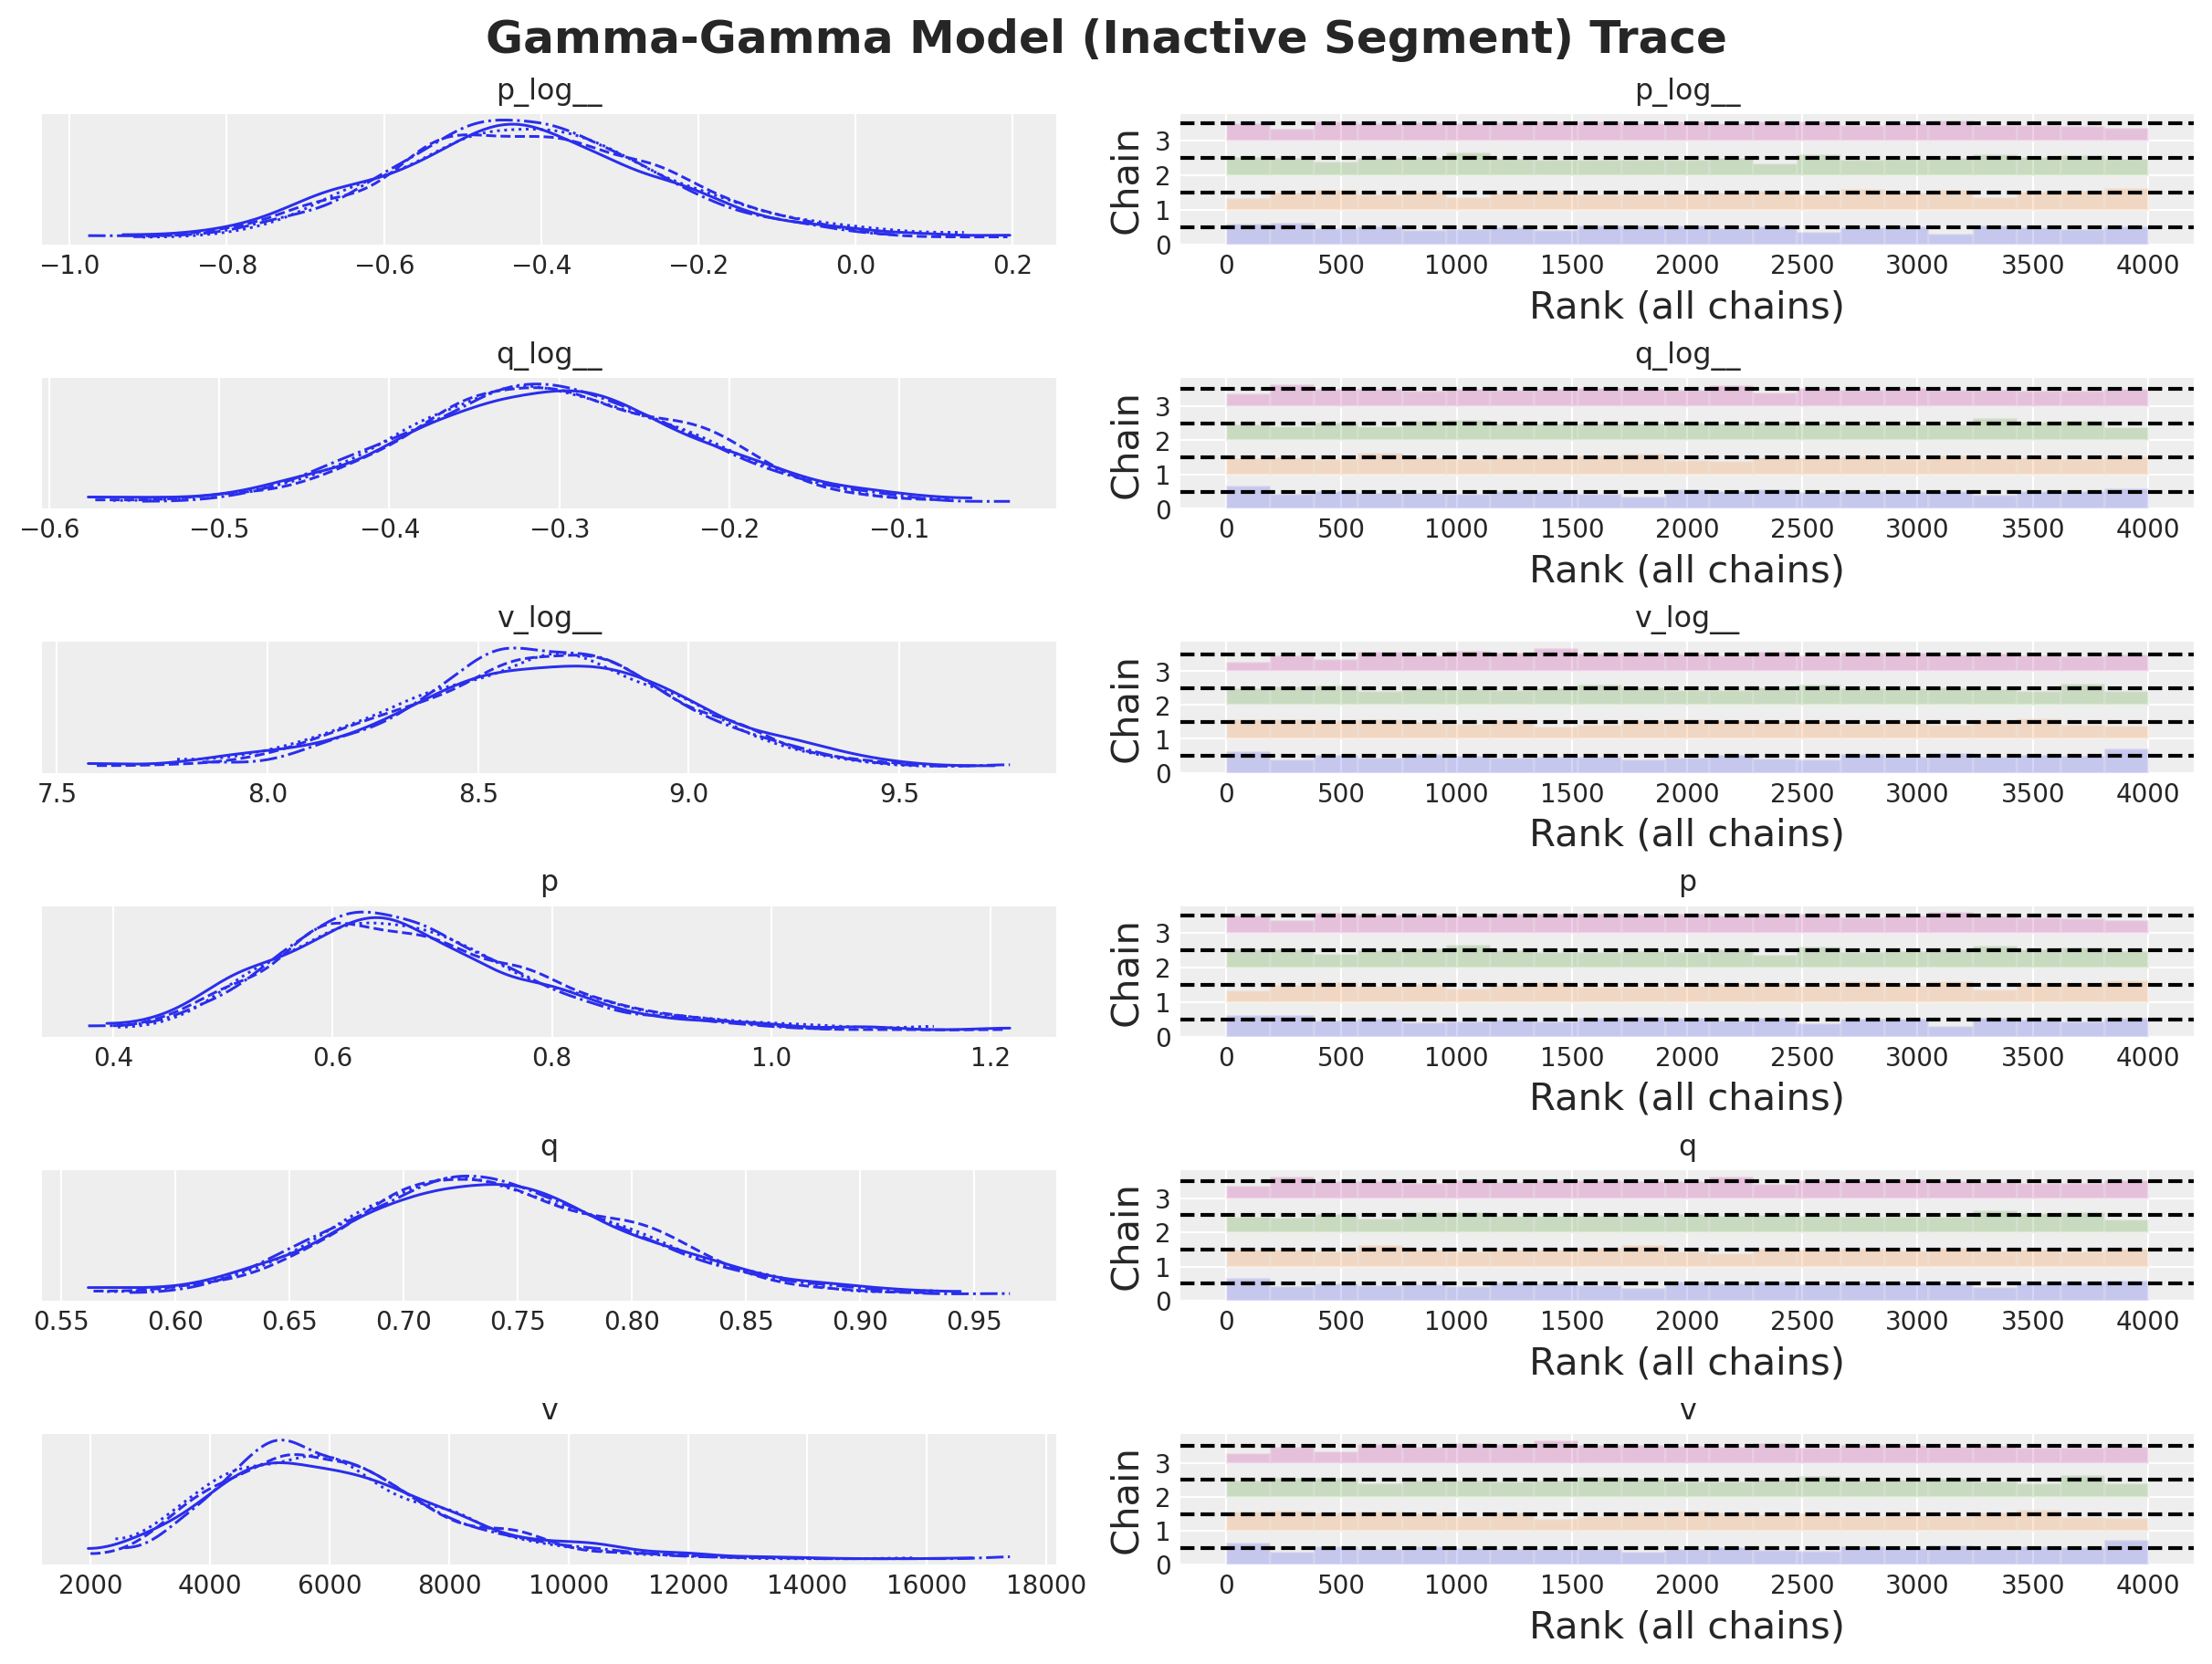

In [36]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Gamma-Gamma Model (Inactive Segment) Trace", fontsize=18, fontweight="bold"
)
plt.show();

### Low Spender Segment

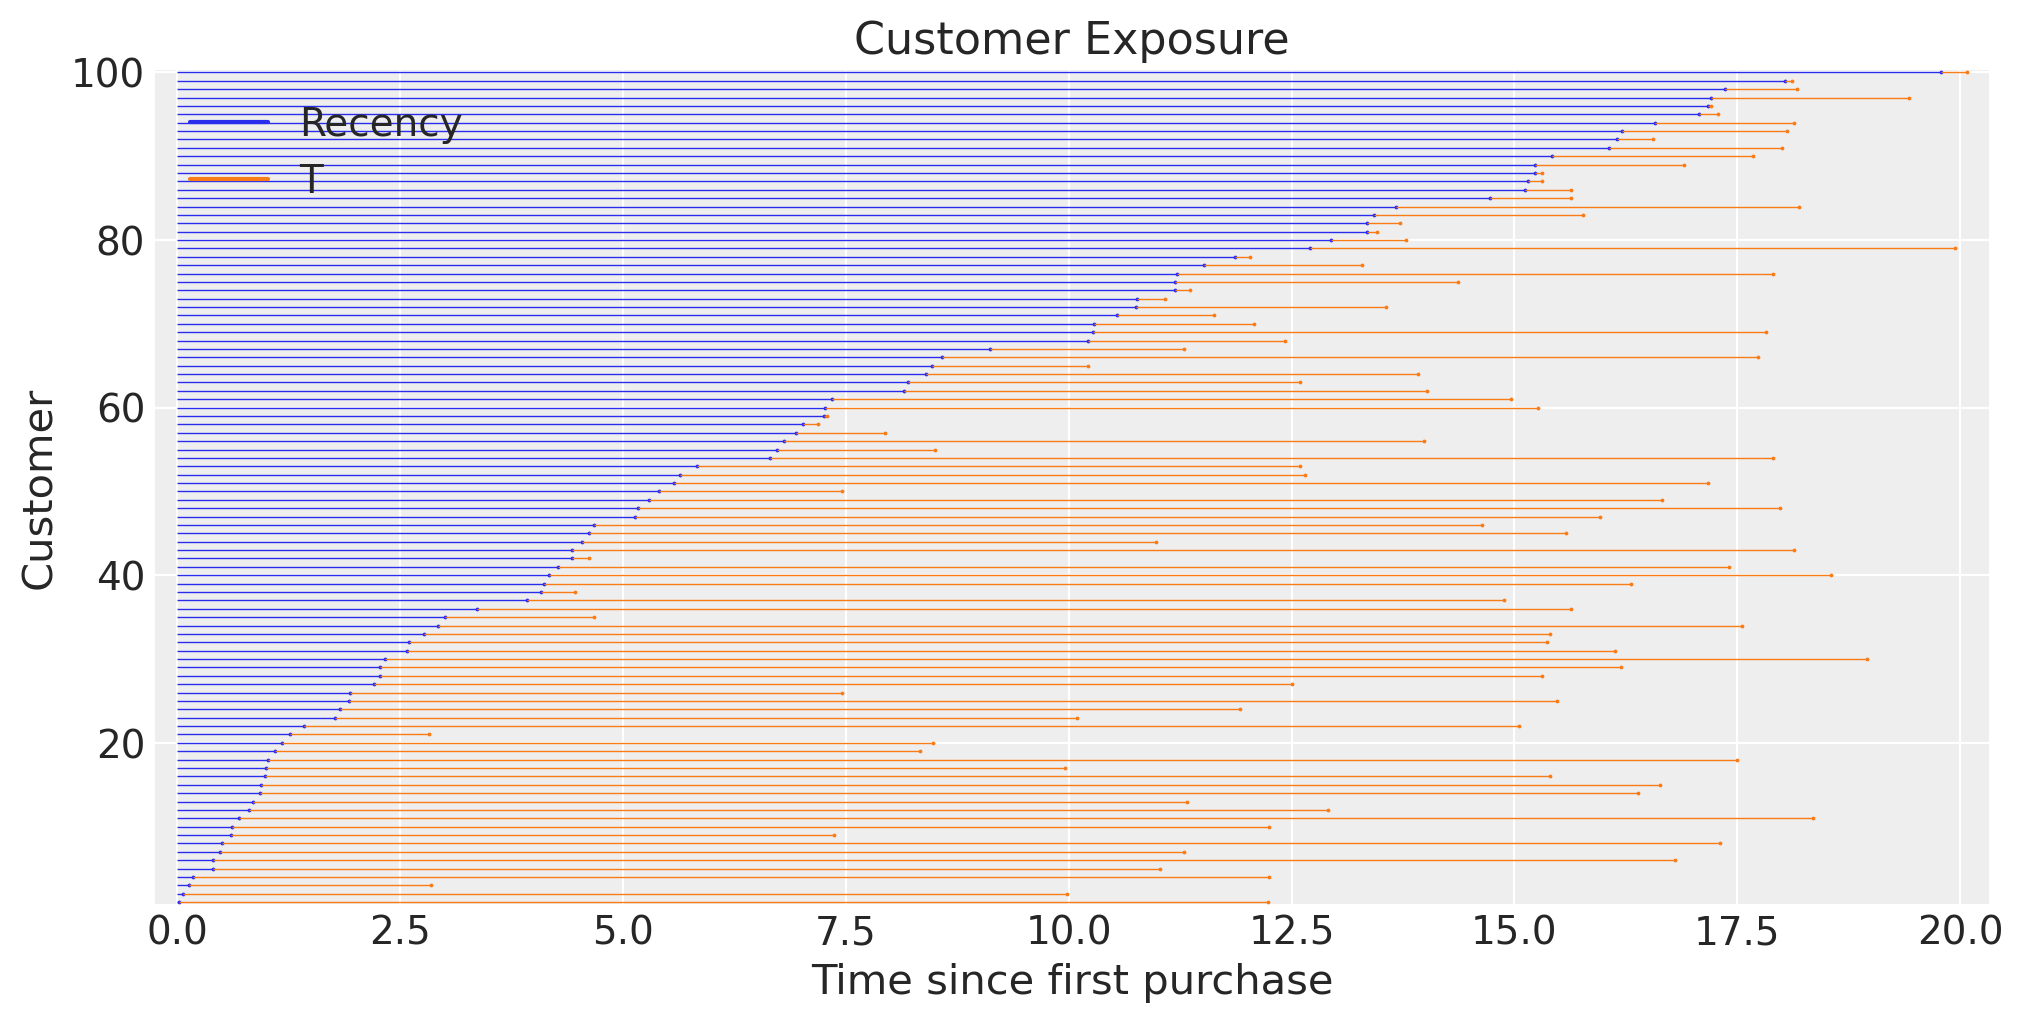

In [37]:
# Customer exposure plot for the low_spender segment

fig, ax = plt.subplots(figsize=(10, 5))
(
    low_spender.sample(n=100, random_state=random_seed)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

In [38]:
model = clv.GammaGammaModel(data=low_spender)
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [39]:
idata_map = model.fit(method="map").posterior.to_dataframe()

Output()

In [40]:
idata_mcmc = model.fit(**sampler_kwargs)

In [41]:
model.fit_summary()

mean       sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
p_log__    -0.60     0.27    -1.09     -0.09       0.01     0.01  1,021.00   
q_log__    -0.30     0.11    -0.53     -0.10       0.00     0.00  1,653.00   
v_log__     8.85     0.46     7.96      9.66       0.01     0.01    980.00   
p           0.57     0.16     0.31      0.87       0.01     0.01  1,021.00   
q           0.74     0.09     0.59      0.90       0.00     0.00  1,653.00   
v       7,755.13 3,691.21 2,263.51 14,458.32     117.88   149.28    980.00   

         ess_tail  r_hat  
p_log__  1,244.00   1.00  
q_log__  1,973.00   1.00  
v_log__  1,180.00   1.00  
p        1,244.00   1.00  
q        1,973.00   1.00  
v        1,180.00   1.00

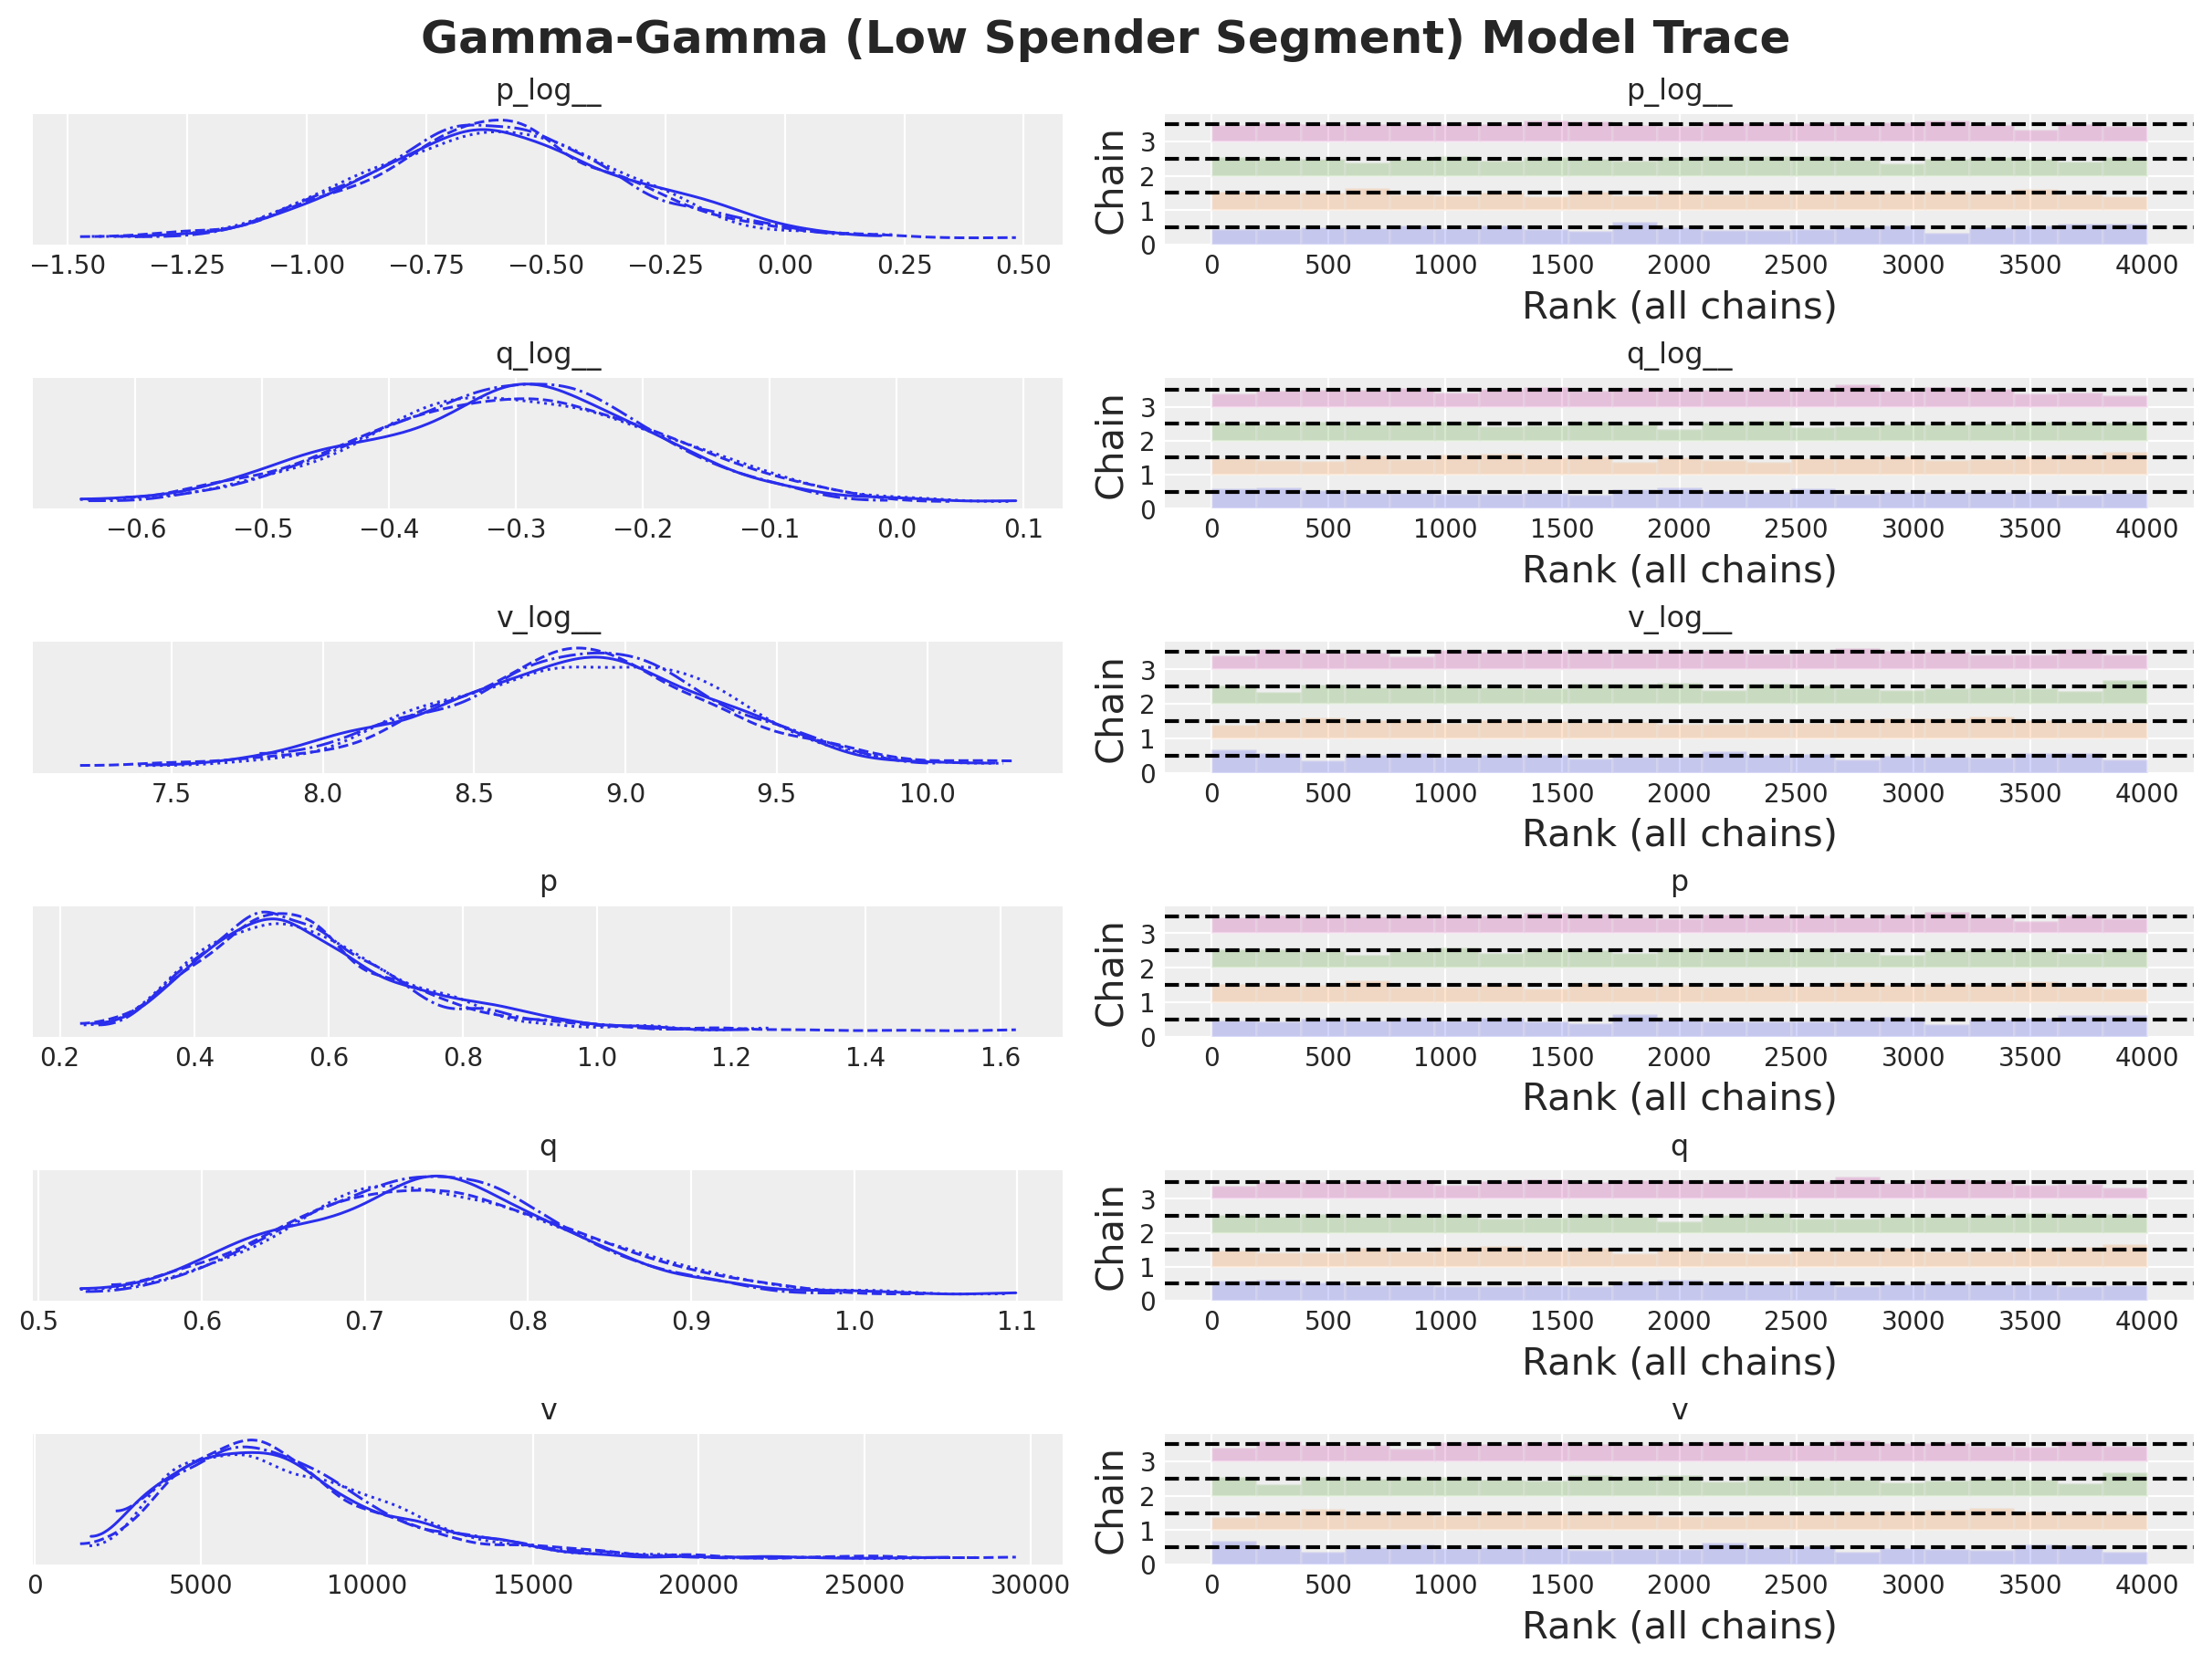

In [42]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Gamma-Gamma (Low Spender Segment) Model Trace", fontsize=18, fontweight="bold"
)
plt.show();

### Premium Segment

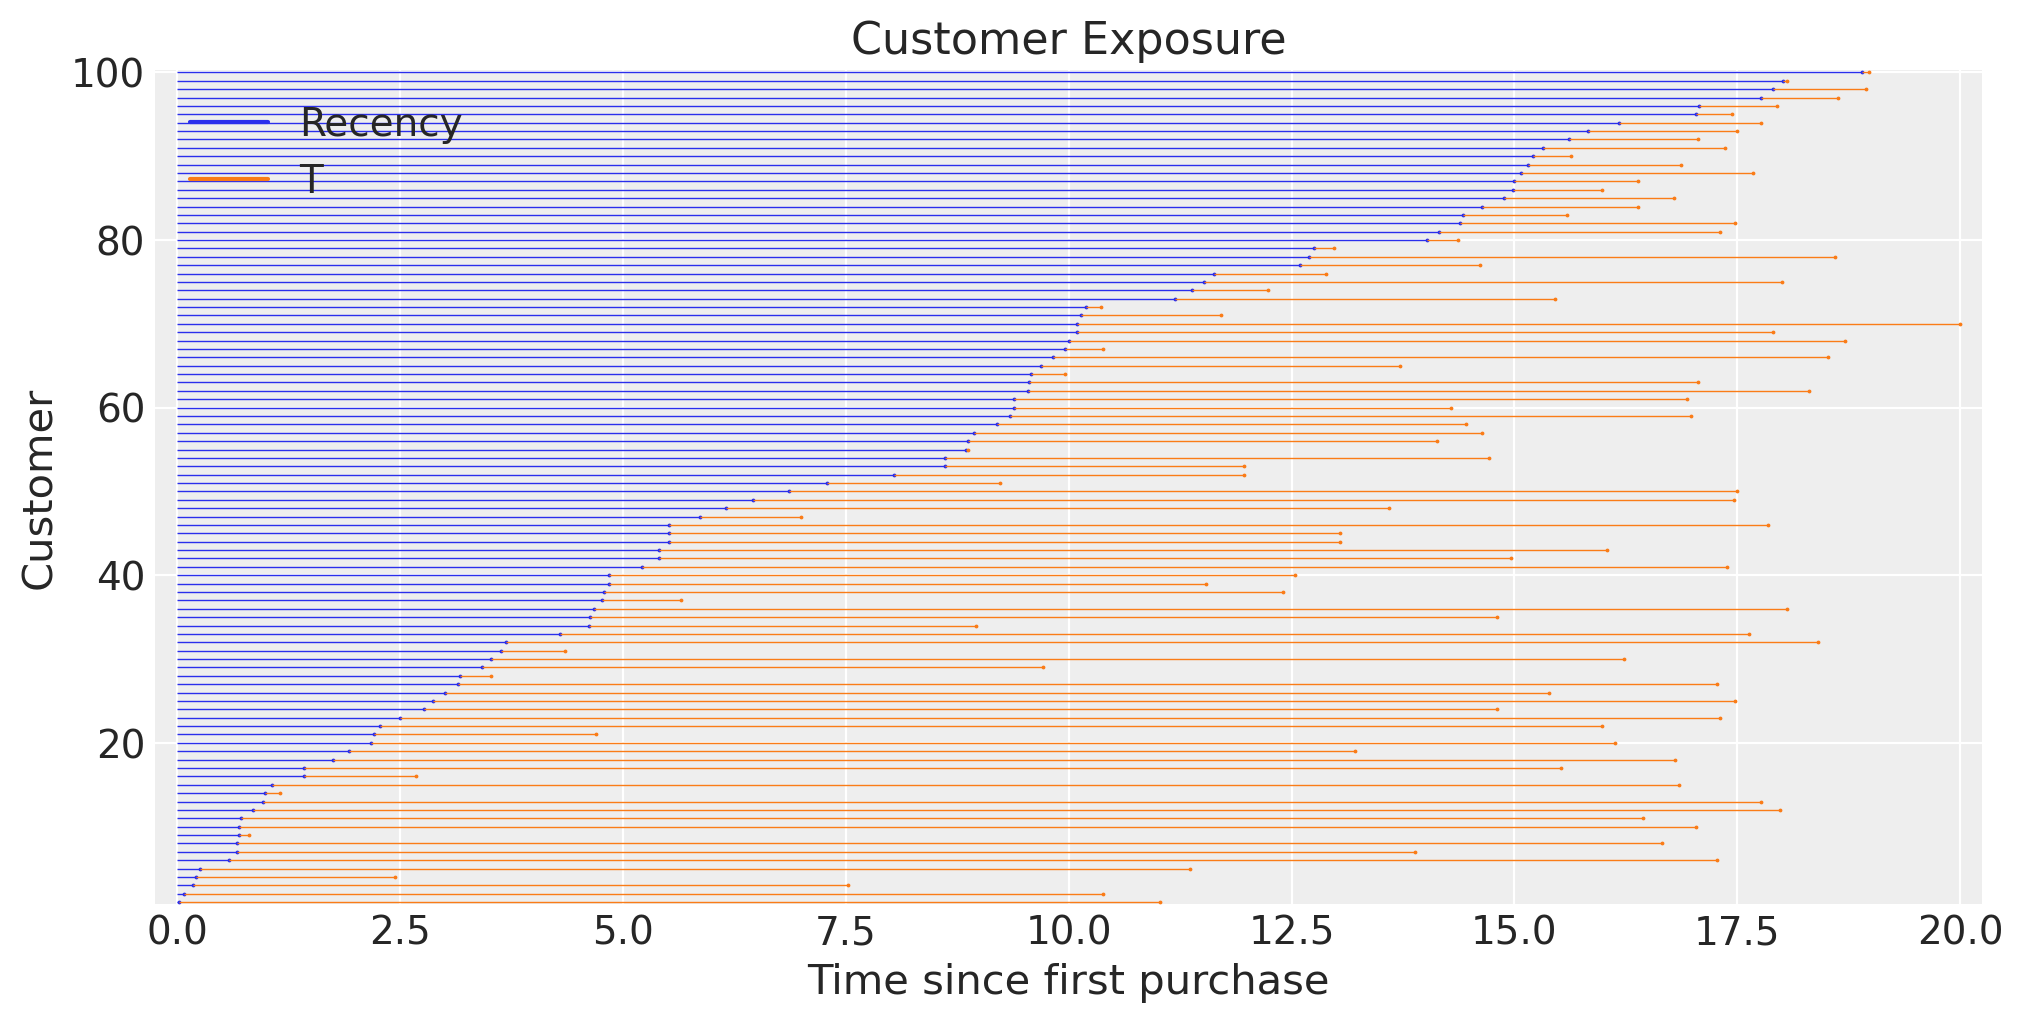

In [43]:
# Customer exposure plot for the premium segment

fig, ax = plt.subplots(figsize=(10, 5))
(
    premium.sample(n=100, random_state=random_seed)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

In [44]:
model = clv.GammaGammaModel(data=premium)
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [45]:
idata_map = model.fit(method="map").posterior.to_dataframe()

Output()

In [46]:
idata_mcmc = model.fit(**sampler_kwargs)

In [47]:
model.fit_summary()

mean                   sd  hdi_3%  \
p_log__                14.07                14.40   -0.62   
q_log__                -0.49                 0.20   -0.71   
v_log__                -6.25                14.82  -21.07   
p       1,153,997,137,034.86 1,154,292,623,571.42    0.54   
q                       0.62                 0.13    0.49   
v                   2,886.43             3,368.59    0.00   

                     hdi_97%          mcse_mean          mcse_sd  ess_bulk  \
p_log__                28.48               7.17             0.01      5.00   
q_log__                -0.19               0.09             0.01      5.00   
v_log__                 9.05               7.38             0.01      5.00   
p       2,334,412,854,023.05 574,833,090,806.53 9,302,027,994.38      5.00   
q                       0.82               0.06             0.01      5.00   
v                   8,549.66           1,443.85            81.42      5.00   

         ess_tail  r_hat  
p_log__    292.00   2.34  
q_log__     13.00   2.16  
v_log__     13.00   2.30  
p          292.00   2.34  
q           13.00   2.16  
v           13.00   2.30

/Users/coltallen/mamba/envs/pymc-marketing-dev/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/coltallen/mamba/envs/pymc-marketing-dev/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


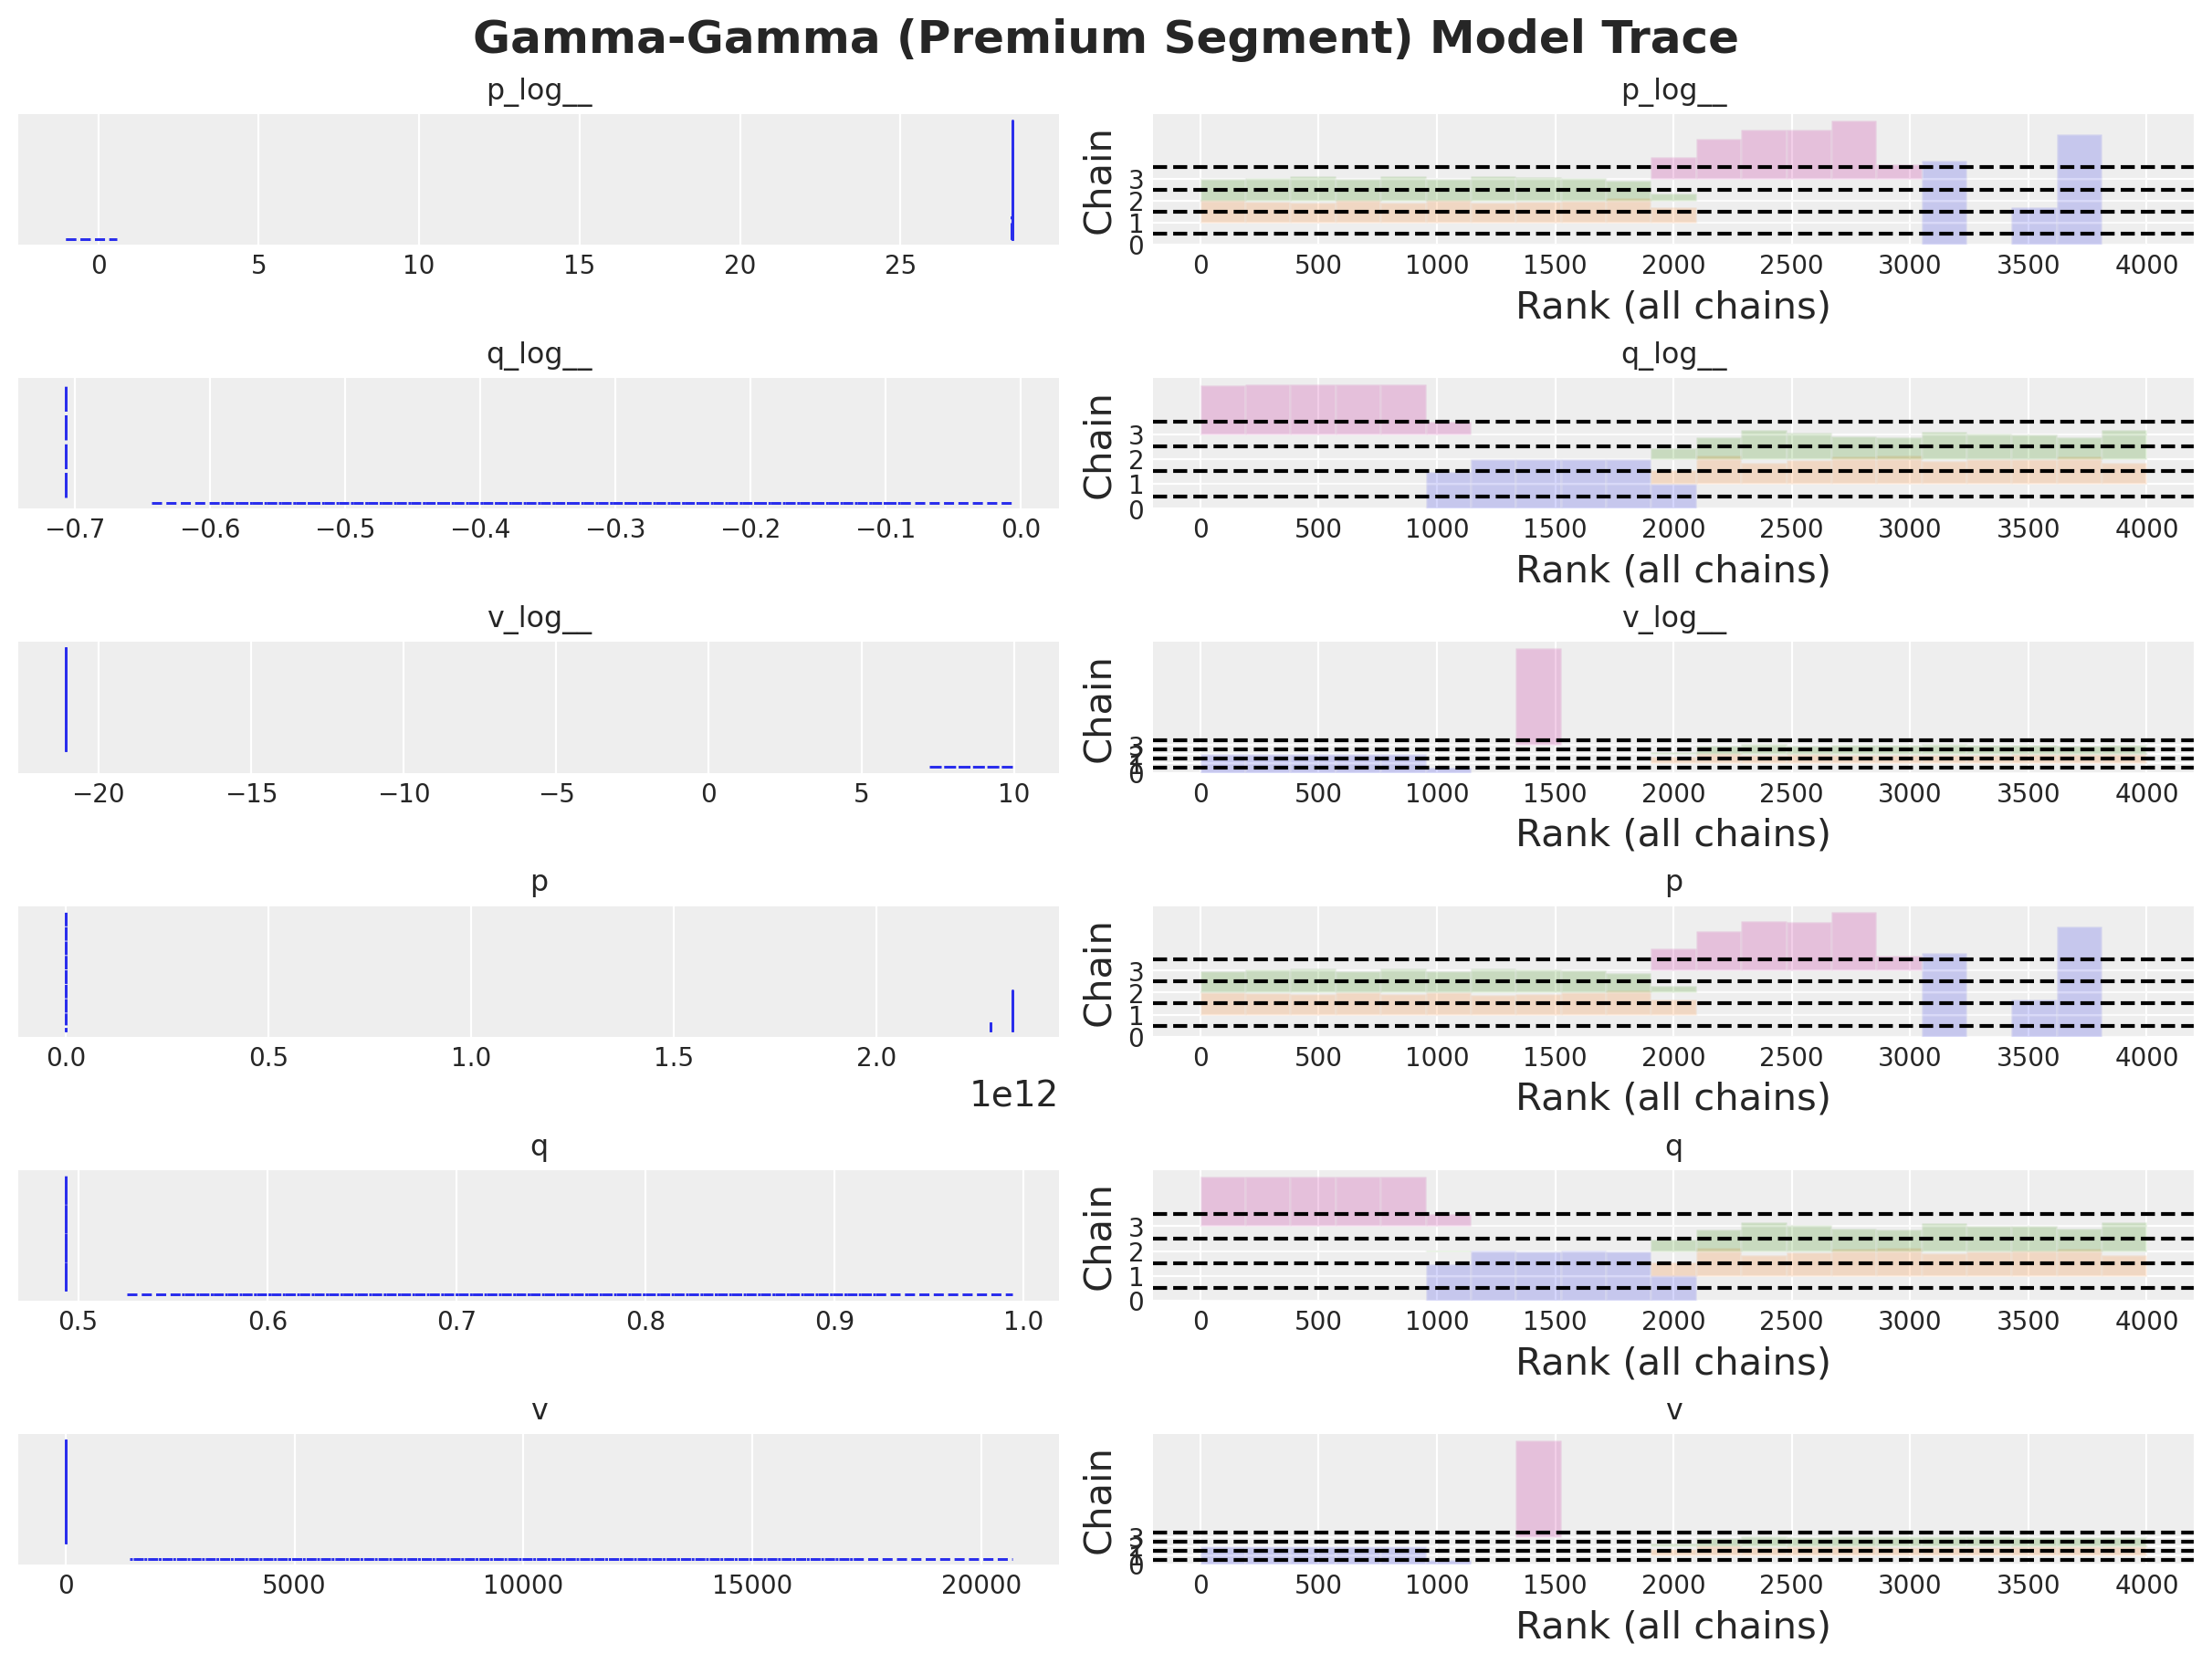

In [48]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Gamma-Gamma (Premium Segment) Model Trace", fontsize=18, fontweight="bold"
)
plt.show();

### Repeat Segment

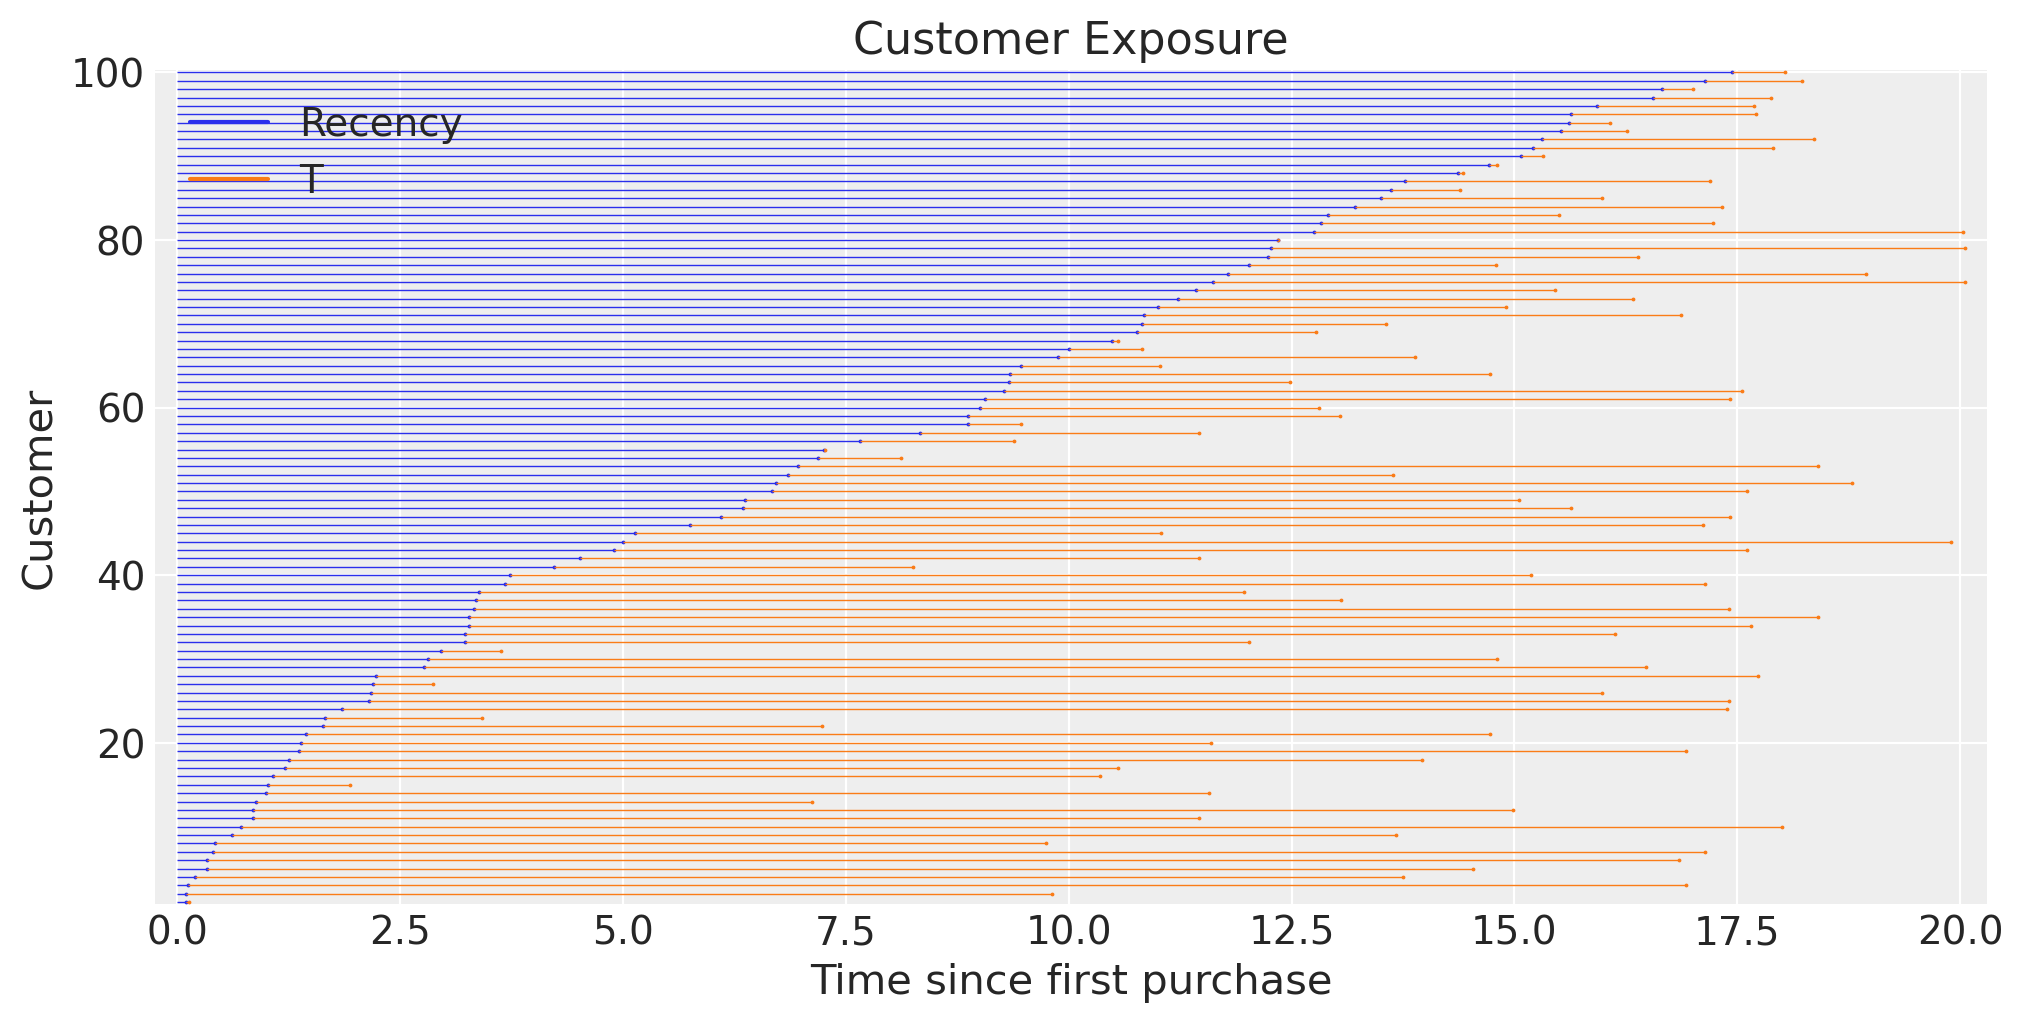

In [49]:
# Customer exposure plot for the repeat segment

fig, ax = plt.subplots(figsize=(10, 5))
(
    repeat.sample(n=100, random_state=random_seed)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

In [50]:
model = clv.GammaGammaModel(data=repeat)
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [51]:
idata_map = model.fit(method="map").posterior.to_dataframe()

Output()

In [52]:
idata_mcmc = model.fit(**sampler_kwargs)

In [53]:
model.fit_summary()

mean                   sd  hdi_3%              hdi_97%  \
p_log__               6.83                12.60   -0.91                28.64   
q_log__              -0.38                 0.22   -0.70                -0.08   
v_log__               1.21                13.17  -21.59                 9.57   
p       688,253,198,845.30 1,192,238,548,004.71    0.34 2,753,012,795,389.20   
q                     0.70                 0.15    0.50                 0.92   
v                 5,795.57             5,011.25    0.00            14,279.90   

                 mcse_mean            mcse_sd  ess_bulk  ess_tail  r_hat  
p_log__               6.27               3.62      7.00     39.00   1.53  
q_log__               0.09               0.04      7.00     12.00   1.58  
v_log__               6.56               3.78      7.00     19.00   1.54  
p       593,730,008,780.42 342,747,328,944.40      7.00     39.00   1.53  
q                     0.06               0.02      7.00     12.00   1.58  
v                 1,692.96             145.82      7.00     19.00   1.54

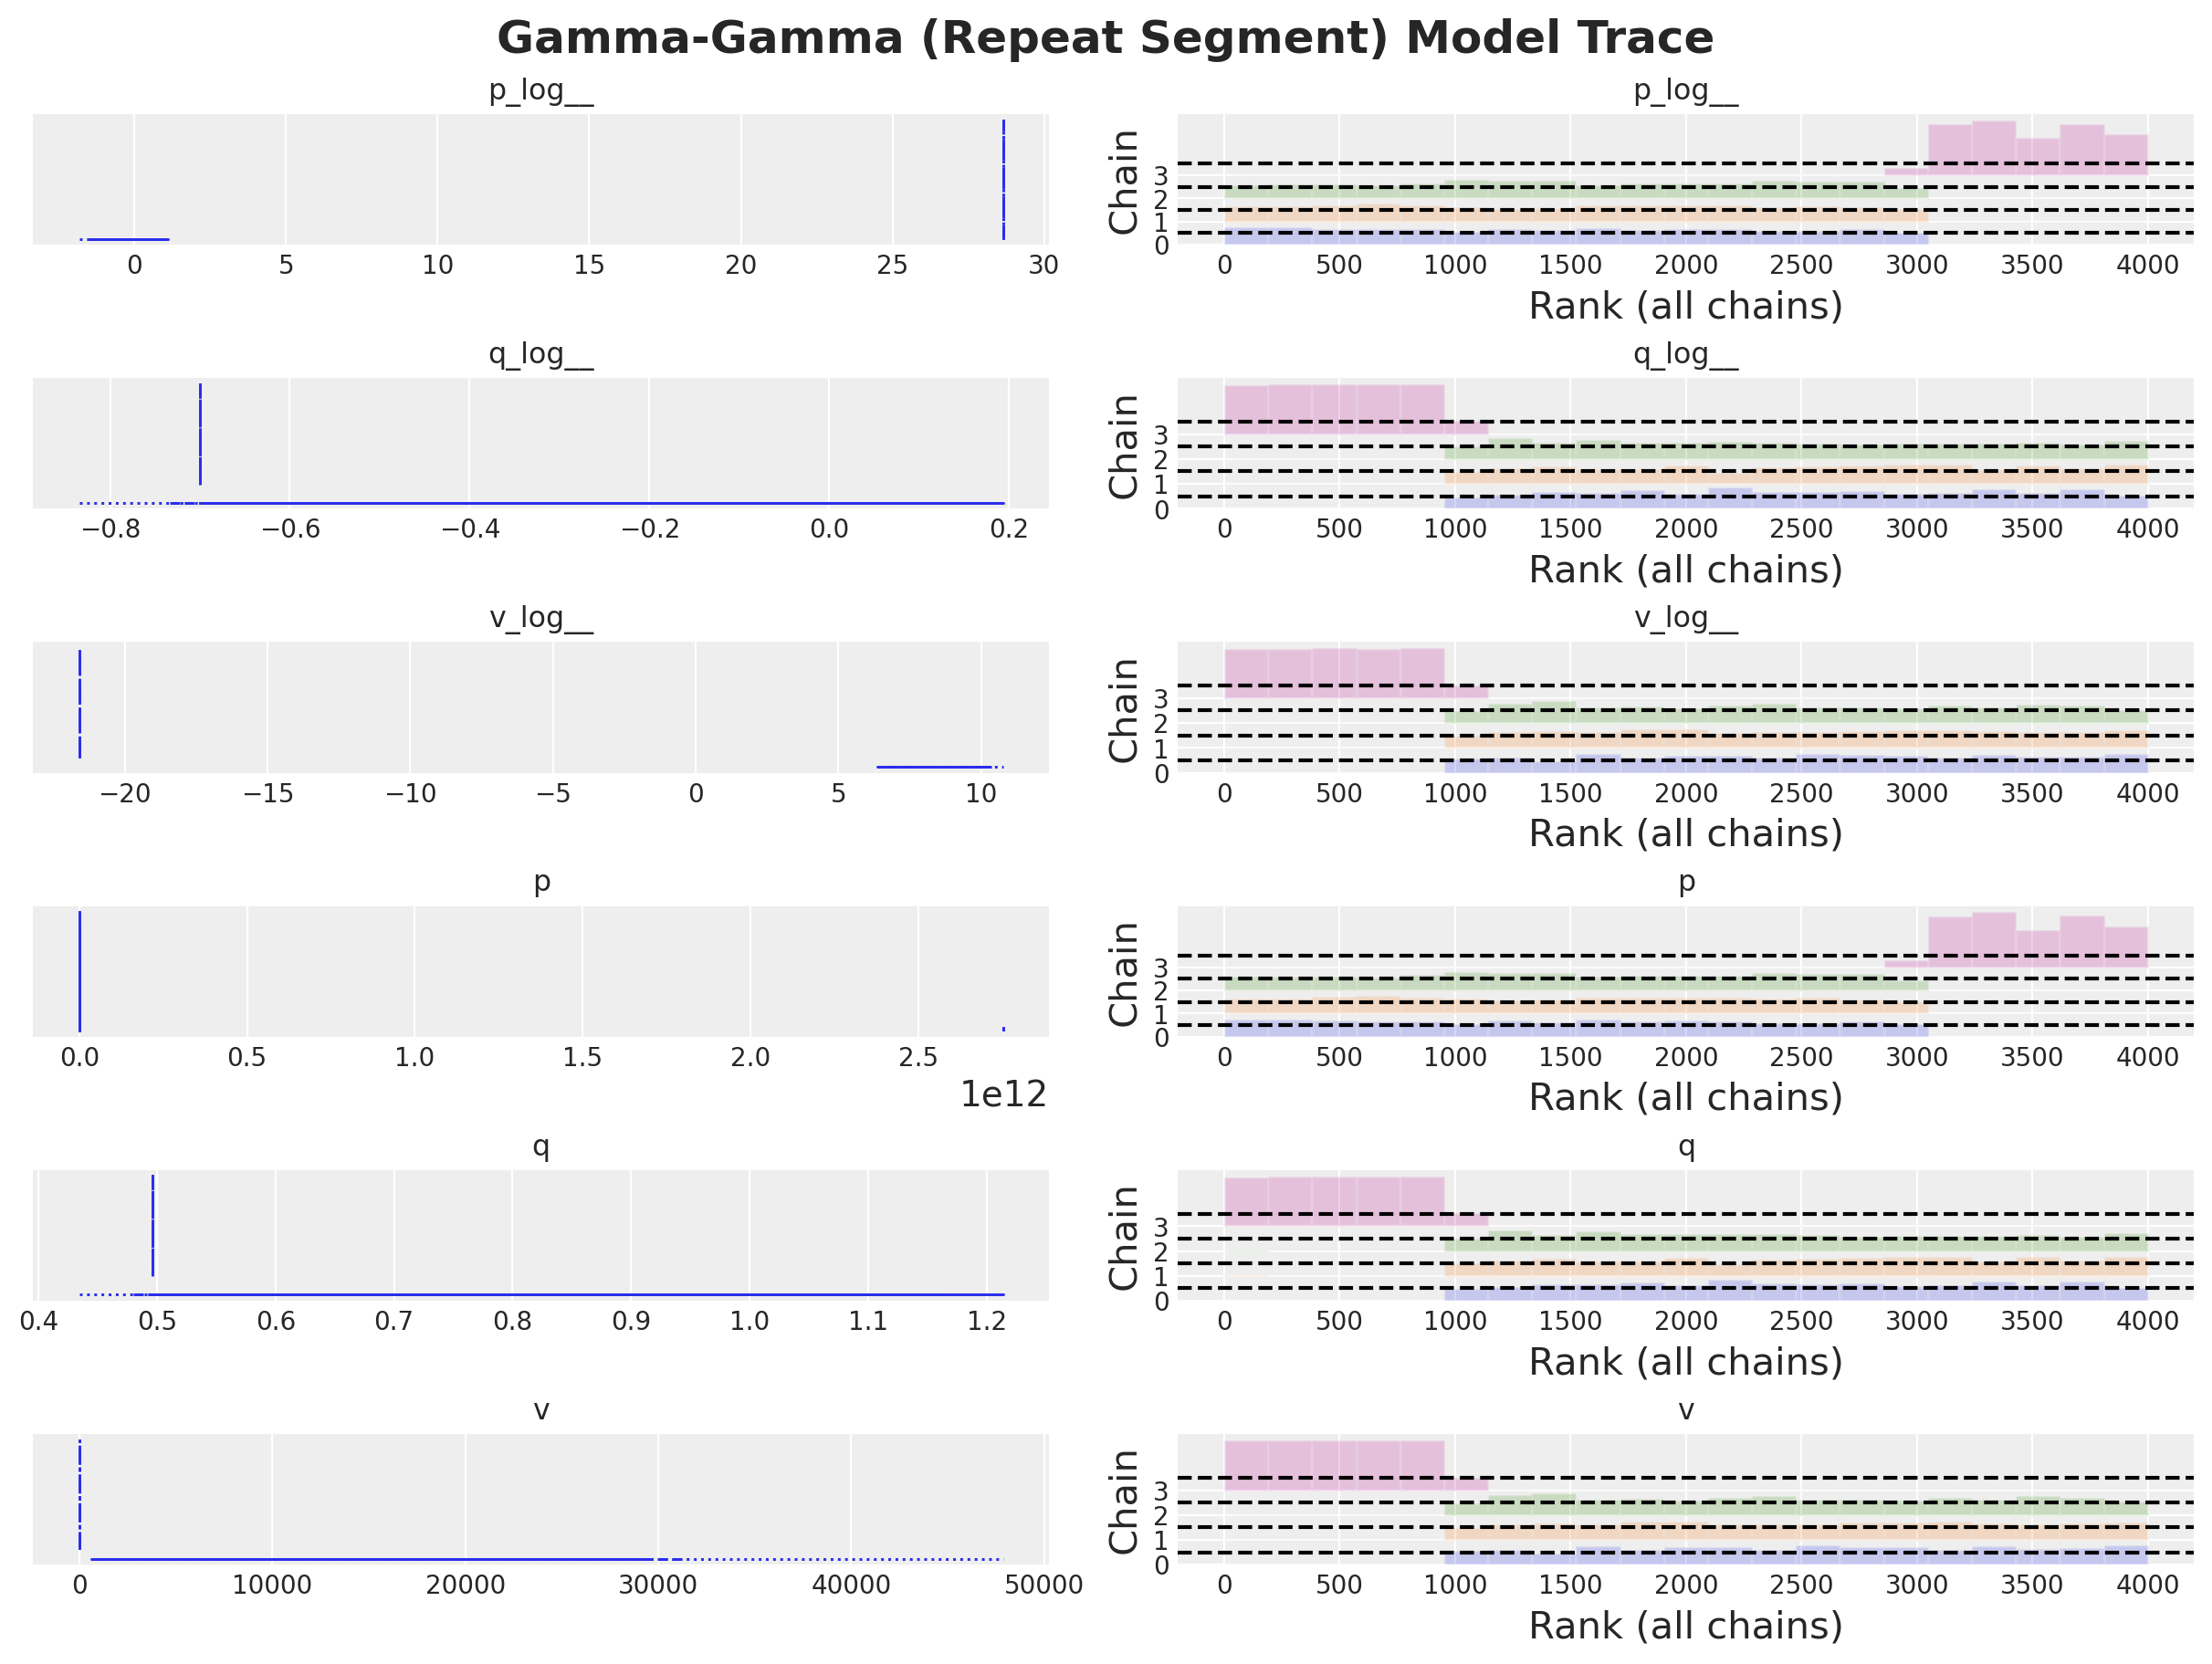

In [54]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Gamma-Gamma (Repeat Segment) Model Trace", fontsize=18, fontweight="bold"
)
plt.show();

### Top Spender Segment

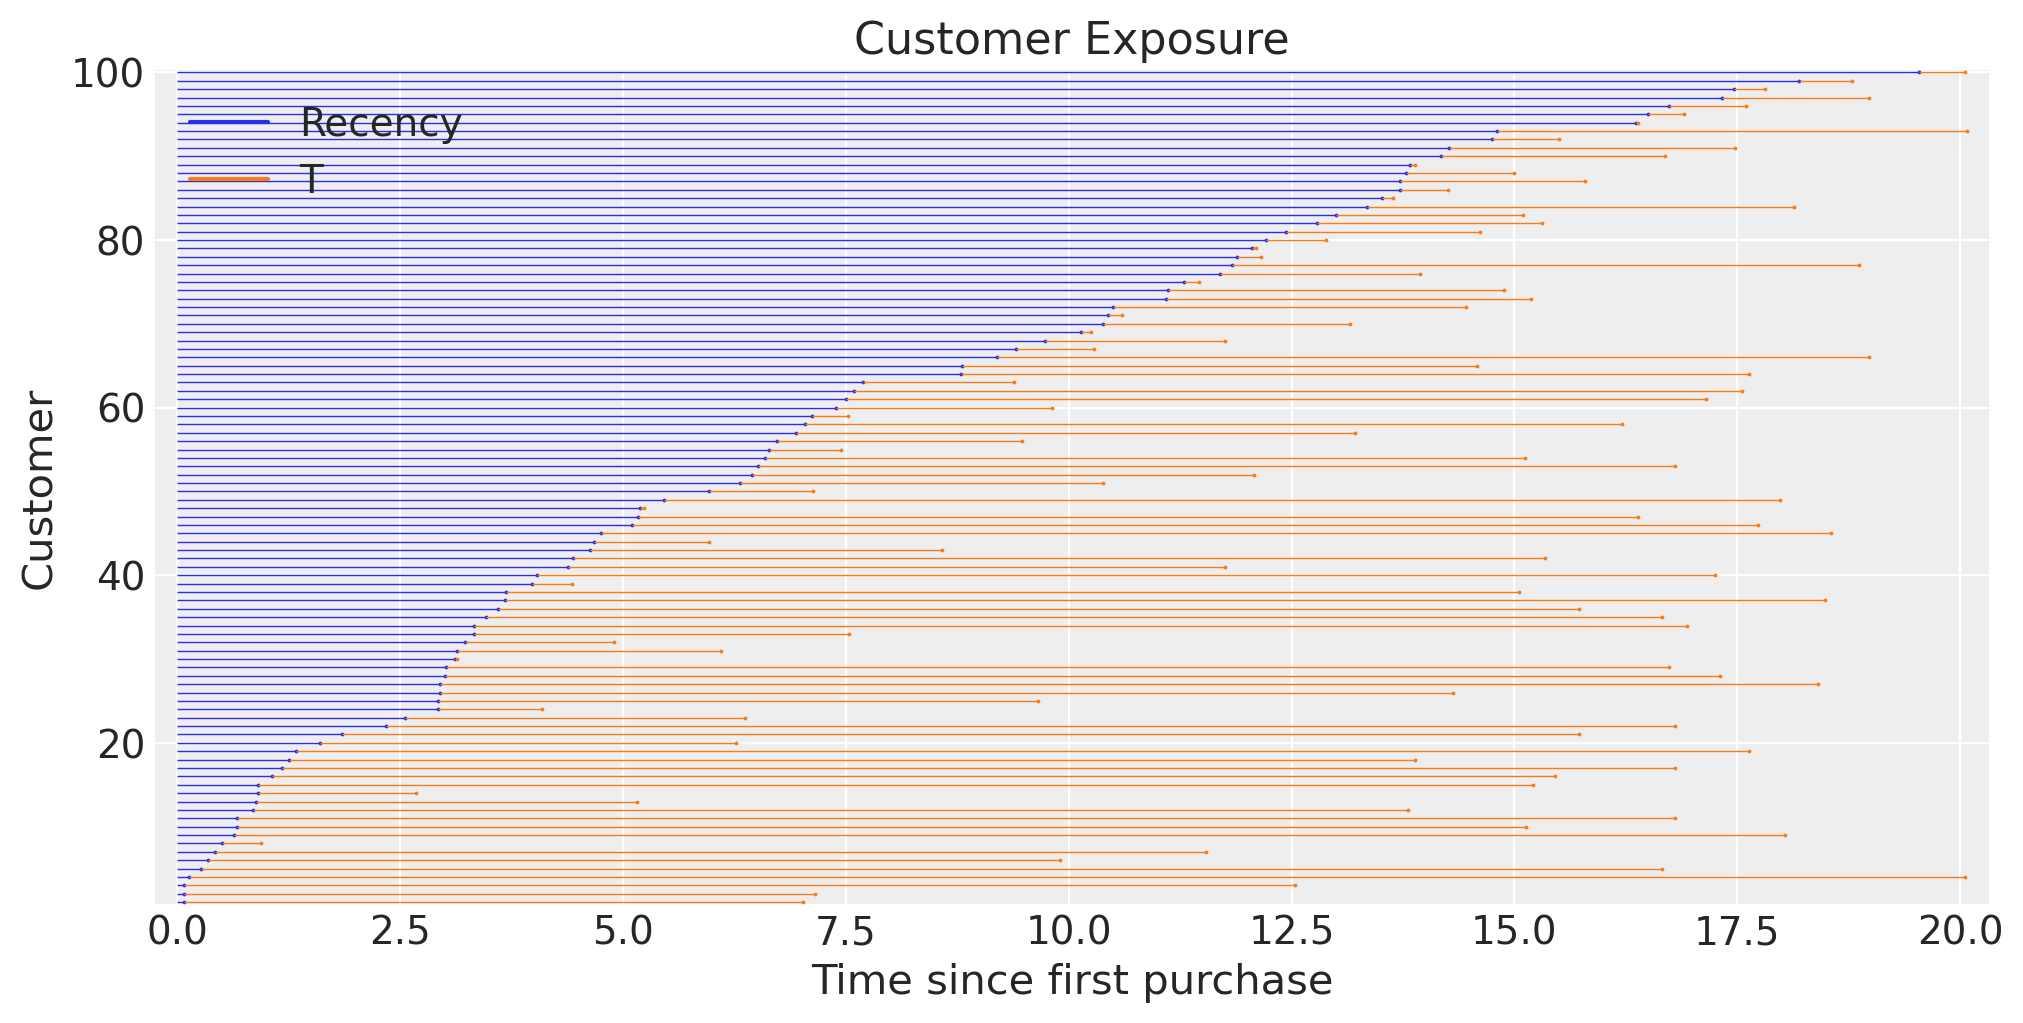

In [55]:
# Customer exposure plot for the top segment

fig, ax = plt.subplots(figsize=(10, 5))
(
    top.sample(n=100, random_state=random_seed)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

In [56]:
model = clv.GammaGammaModel(data=top)
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [57]:
idata_map = model.fit(method="map").posterior.to_dataframe()

Output()

In [58]:
idata_mcmc = model.fit(**sampler_kwargs)

In [59]:
model.fit_summary()

mean                 sd  hdi_3%            hdi_97%  \
p_log__              6.12              11.88   -0.97              26.69   
q_log__             -0.14               0.32   -0.67               0.18   
v_log__              2.35              12.73  -19.69              10.12   
p       97,608,170,411.20 169,083,447,137.22    0.30 390,432,681,648.49   
q                    0.91               0.25    0.52               1.20   
v               12,706.82           8,628.26    0.00          24,924.72   

                mcse_mean           mcse_sd  ess_bulk  ess_tail  r_hat  
p_log__              5.92              3.41      7.00     19.00   1.57  
q_log__              0.15              0.08      7.00     11.00   1.59  
v_log__              6.34              3.66      7.00     14.00   1.54  
p       84,202,877,621.61 48,608,476,862.27      7.00     19.00   1.57  
q                    0.11              0.05      7.00     11.00   1.59  
v                3,693.04          1,468.47      7.00     14.00   1.54

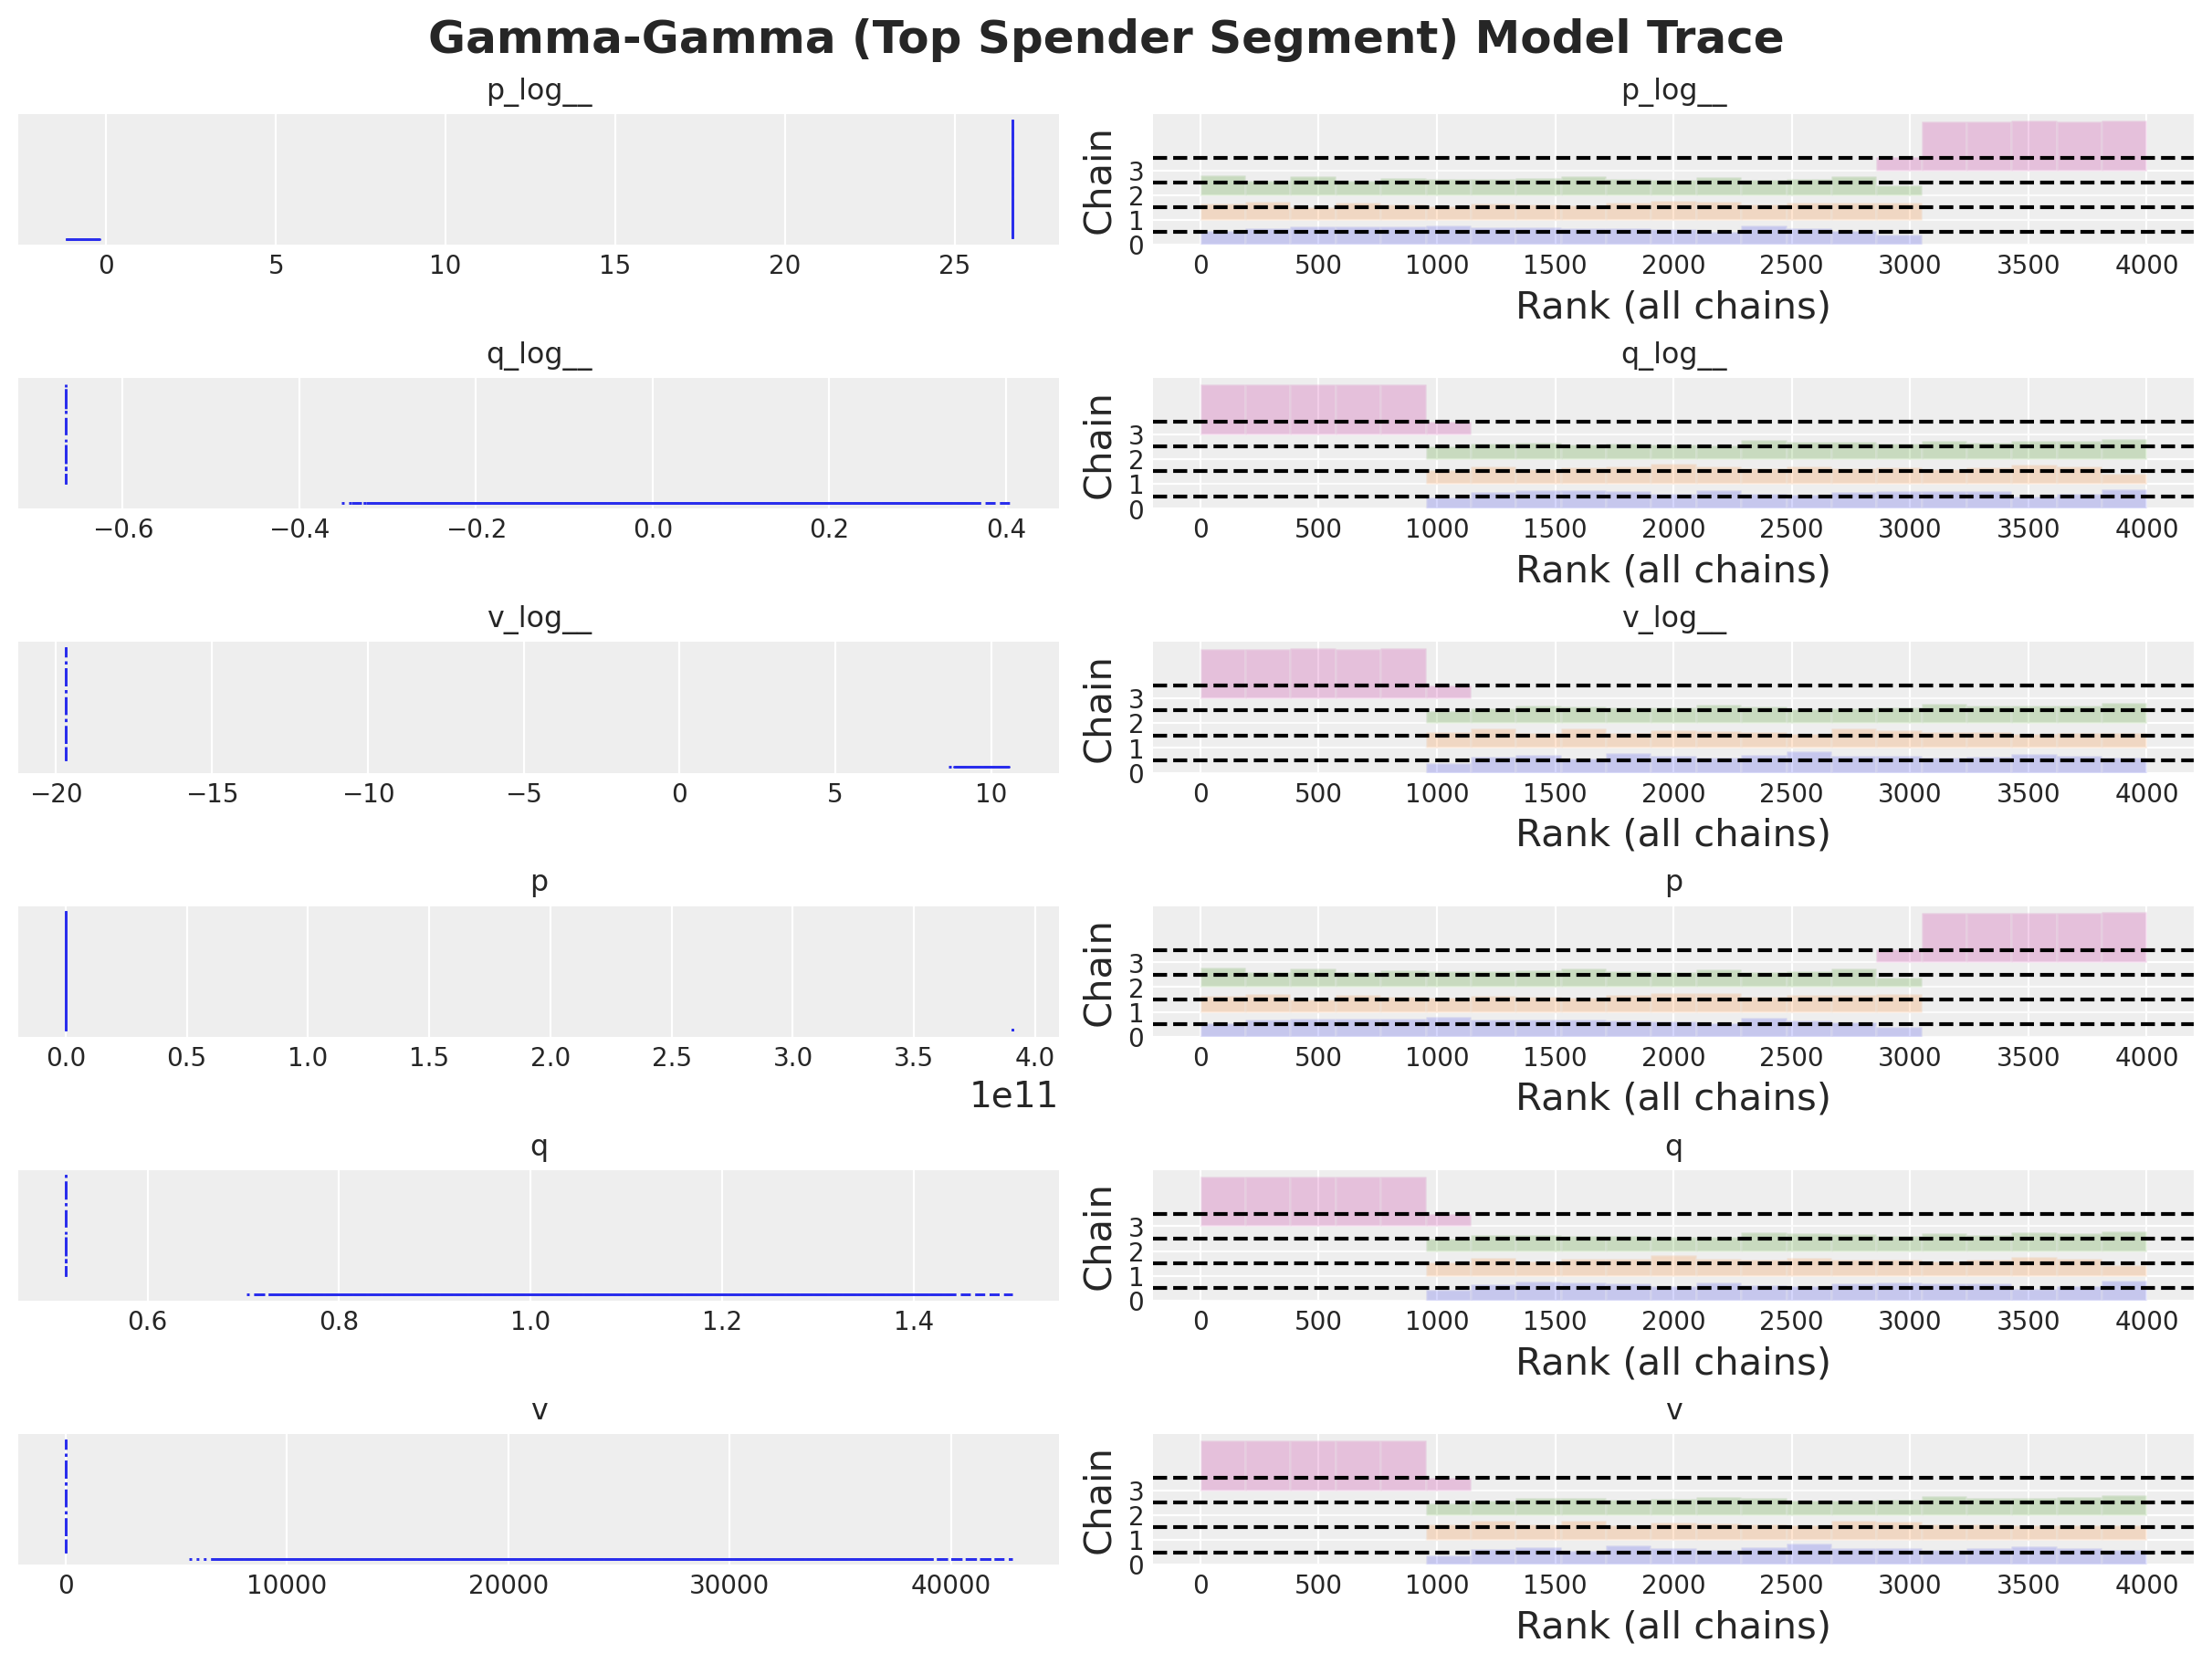

In [60]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Gamma-Gamma (Top Spender Segment) Model Trace", fontsize=18, fontweight="bold"
)
plt.show();

# Order Data Re-preprocessing for GammaGammaIndividual Model Fitting

In [59]:
order_data_indiv = order_data[
    ["INST_KEY", "ORDER_DATE", "M_NET_SALES", "INST_SCRAPPED_DATE"]
].copy()

order_data_indiv = order_data_indiv[
    (order_data_indiv["M_NET_SALES"] > 50)
    & (order_data_indiv["M_NET_SALES"] < 4000000)
    & (order_data_indiv["INST_SCRAPPED_DATE"].isna())
].copy()

In [60]:
order_data_indiv

INST_KEY  ORDER_DATE  M_NET_SALES  INST_SCRAPPED_DATE
0          48.00  2004-02-10    13,911.36                 NaN
6          63.00  2004-02-12     3,994.43                 NaN
7         435.00  2004-02-02       938.11                 NaN
10         41.00  2004-02-09     2,488.16                 NaN
12        155.00  2004-02-11     1,810.03                 NaN
...          ...         ...          ...                 ...
199641  3,400.00  2024-01-29    13,893.57                 NaN
199642    464.00  2024-01-11     5,633.87                 NaN
199644  2,548.00  2024-01-30        86.30                 NaN
199647  3,927.00  2023-12-15    18,755.00                 NaN
199660  3,967.00  2024-01-11    30,624.90                 NaN

[46619 rows x 4 columns]

In [61]:
segments_ids = rfm_df_model[["customer_id", "segment"]]

In [62]:
joined_indiv = pd.merge(
    left=order_data_indiv,
    right=segments_ids,
    left_on="INST_KEY",
    right_on="customer_id",
    how="inner",
)

In [63]:
joined_indiv

INST_KEY  ORDER_DATE  M_NET_SALES  INST_SCRAPPED_DATE  customer_id  \
0         48.00  2004-02-10    13,911.36                 NaN           48   
1         63.00  2004-02-12     3,994.43                 NaN           63   
2        435.00  2004-02-02       938.11                 NaN          435   
3         41.00  2004-02-09     2,488.16                 NaN           41   
4        155.00  2004-02-11     1,810.03                 NaN          155   
...         ...         ...          ...                 ...          ...   
30223  1,678.00  2024-01-19     7,159.25                 NaN         1678   
30224  1,284.00  2024-01-01       195.42                 NaN         1284   
30225     22.00  2024-01-12     1,197.50                 NaN           22   
30226    464.00  2024-01-11     5,633.87                 NaN          464   
30227  2,548.00  2024-01-30        86.30                 NaN         2548   

                segment  
0           Top Spender  
1           Low Spender  
2      At Risk Customer  
3      At Risk Customer  
4       Repeat Customer  
...                 ...  
30223  Premium Customer  
30224  Premium Customer  
30225  Premium Customer  
30226  At Risk Customer  
30227       Low Spender  

[30228 rows x 6 columns]

In [64]:
indiv_model_df = joined_indiv[["INST_KEY", "M_NET_SALES"]].copy()

indiv_model_df.rename(
    columns={
        "INST_KEY": "customer_id",
        "M_NET_SALES": "individual_transaction_value",
    },
    inplace=True,
)

In [65]:
indiv_model_df

customer_id  individual_transaction_value
0            48.00                     13,911.36
1            63.00                      3,994.43
2           435.00                        938.11
3            41.00                      2,488.16
4           155.00                      1,810.03
...            ...                           ...
30223     1,678.00                      7,159.25
30224     1,284.00                        195.42
30225        22.00                      1,197.50
30226       464.00                      5,633.87
30227     2,548.00                         86.30

[30228 rows x 2 columns]

## At-Risk GammaGammaIndividual

In [72]:
at_risk_ind = indiv_model_df[indiv_model_df["customer_id"].isin(at_risk["customer_id"])]

In [73]:
at_risk_ind.reset_index(drop=True, inplace=True)
at_risk_ind["customer_id"] = at_risk_ind["customer_id"].astype(int)
at_risk_ind.index = at_risk_ind["customer_id"]

C:\Users\adria\AppData\Local\Temp\ipykernel_182504\2116515121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  at_risk_ind["customer_id"] = at_risk_ind["customer_id"].astype(int)


In [74]:
at_risk_ind

customer_id  individual_transaction_value
customer_id                                           
435                  435                        938.11
41                    41                      2,488.16
87                    87                        284.62
58                    58                      3,150.58
435                  435                      2,354.66
...                  ...                           ...
1009                1009                      3,443.00
119                  119                      1,496.00
860                  860                      4,850.79
860                  860                        564.02
464                  464                      5,633.87

[1555 rows x 2 columns]

In [69]:
at_risk_ind = at_risk_ind.drop(columns="customer_id")

In [70]:
at_risk_ind

individual_transaction_value
customer_id                              
435                                938.11
41                               2,488.16
87                                 284.62
58                               3,150.58
435                              2,354.66
...                                   ...
1009                             3,443.00
119                              1,496.00
860                              4,850.79
860                                564.02
464                              5,633.87

[1555 rows x 1 columns]

In [71]:
model = clv.GammaGammaModelIndividual(data=at_risk_ind)

ValueError: Required column customer_id missing

In [ ]:
model.fit(method="mcmc", sampler_kwargs=sampler_kwargs)

Initializing NUTS using jitter+adapt_diag...
C:\Users\adria\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


In [ ]:
# indiv_model.fit()